In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.features import preprocessing

2023-06-12 12:17:39.261097: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 12:17:39.838291: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:$LD_LIBRARY_PATH
2023-06-12 12:17:39.838353: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:$LD_LIBRARY_PATH
2023-06-12 12:17:39.838357: W tensorflow/compiler/tf

In [2]:
# Bypass issues with invoking notebook with server arguments
sys.argv.clear()
sys.argv.append("")

In [3]:
%run utils/attention_graph.py
%run utils/mlflow_query.py
%run utils/loading.py
%run utils/comparison.py
%run utils/ranks.py

In [44]:
mlflow_helper = MlflowHelper(pkl_file=Path("mlflow_run_df.pkl"), experiment_id="519815984018260895")
mlflow_helper.query_valid_runs(pkl_file=Path("mlflow_run_df.pkl"))

Querying data per run...: 0it [00:00, ?it/s]


Queried 0 runs from MLFlow for mimic


Querying data per run...: 100%|██████████| 334/334 [00:03<00:00, 107.26it/s]


Queried 334 runs from MLFlow for huawei_logs


Querying data per run...: 0it [00:00, ?it/s]


Queried 334 runs from MLFlow for hdfs


Querying data per run...: 0it [00:00, ?it/s]

Queried 334 runs from MLFlow for tbird_logs


In [89]:
huawei_df = mlflow_helper.huawei_run_df(
     valid_x_columns=["fine_log_cluster_template_drain", "coarse_log_cluster_template_drain", "", "medium_log_cluster_template_drain", "fine_log_cluster_template_spell", "coarse_log_cluster_template_spell",
                     "medium_log_cluster_template_spell", "fine_log_cluster_template_nulog", "coarse_log_cluster_template_nulog", "medium_log_cluster_template_nulog"],
    valid_y_columns=["attributes"],
    include_drain_hierarchy=True,
)
huawei_df = huawei_df[
    huawei_df["data_params_ModelConfigbase_feature_embeddings_trainable"].astype(str) == "False"
    ]

huawei_df.groupby(by=[
    "data_params_SequenceConfigx_sequence_column_name",
    "data_params_SequenceConfigy_sequence_column_name",
    "data_tags_model_type",
]).agg({
    "info_run_id": len
})

info_run_id
data_params_SequenceConfigx_sequence_column_name data_params_SequenceConfigy_sequence_column_name data_tags_model_type             
                                                 attributes                                       gram_logs                      15
                                                                                                  simple                         40
coarse_log_cluster_template_drain                attributes                                       gram_logs                       3
                                                                                                  simple                         16
coarse_log_cluster_template_nulog                attributes                                       gram_logs                       3
                                                                                                  simple                         15
coarse_log_cluster_template_spell                attributes                                       gram_logs                       3
                                                                                                  simple                         15
fine_log_cluster_template_drain                  attributes                                       gram_logs                       3
                                                                                                  simple                         16
fine_log_cluster_template_nulog                  attributes                                       gram_logs                       3
                                                                                                  simple                         16
fine_log_cluster_template_spell                  attributes                                       gram_logs                       3
                                                                                                  simple                         15
medium_log_cluster_template_drain                attributes                                       gram_logs                       3
                                                                                                  simple                         16
medium_log_cluster_template_nulog                attributes                                       gram_logs                       3
                                                                                                  simple                         15
medium_log_cluster_template_spell                attributes                                       gram_logs                       3
                                                                                                  simple                         15

In [45]:
huawei_df = mlflow_helper.huawei_run_df(
    valid_x_columns=["fine_log_cluster_template", "medium_log_cluster_template", "coarse_log_cluster_template", ""],
    valid_y_columns=["attributes"],
    include_drain_hierarchy=True,
)
huawei_df = huawei_df[
    huawei_df["data_params_ModelConfigbase_feature_embeddings_trainable"].astype(str) == "False"
    ]

huawei_df.groupby(by=[
    "data_params_SequenceConfigx_sequence_column_name",
    "data_params_SequenceConfigy_sequence_column_name",
    "data_tags_model_type",
]).agg({
    "info_run_id": len
})

info_run_id
data_params_SequenceConfigx_sequence_column_name data_params_SequenceConfigy_sequence_column_name data_tags_model_type             
                                                 attributes                                       gram_logs                      15
                                                                                                  simple                         40
coarse_log_cluster_template                      attributes                                       gram_logs                      12
                                                                                                  simple                         25
fine_log_cluster_template                        attributes                                       gram_logs                      13
                                                                                                  simple                         25
medium_log_cluster_template                      attributes                                       gram_logs                      13
                                                                                                  simple                         25

In [90]:
huawei_metrics_df = mlflow_helper.load_best_metrics_for_ids(set(huawei_df["info_run_id"]))

Querying metrics for runs: 100%|██████████| 221/221 [00:13<00:00, 16.36it/s]


In [110]:
df = huawei_metrics_df.copy()
df["data_params_SequenceConfigx_sequence_column_name"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: {
    "": "attention_log_cluster_template"
}.get(x, x))
df = df[
        df["data_params_SequenceConfigy_sequence_column_name"].apply(lambda x: x == "attributes")
        & df["data_tags_model_type"].apply(lambda x: x == "simple")
        & df["data_params_ModelConfigbase_hidden_embeddings_trainable"].apply(lambda x: x == "False")
        & df["data_params_HuaweiPreprocessorConfigremove_dates_from_payload"].apply(lambda x: x == "True")
        & df["data_params_ExperimentConfign_epochs"].apply(lambda x: x == "25")
        & df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: x == "attention_log_cluster_template")
        & df["data_params_HuaweiPreprocessorConfiglog_parser"].apply(lambda x: x == "spell")
        & df["data_params_HuaweiPreprocessorConfigaggregated_log_file"].apply(lambda x: x == "data/logs_aggregated_concurrent_2000.csv")
        ]
df["data_metrics_x_vocab_size"].median()

374.0

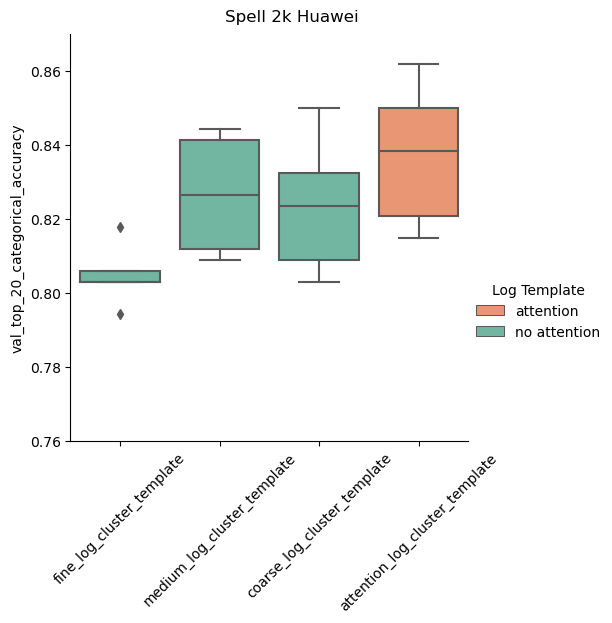

In [24]:
df = huawei_metrics_df.copy()
custom_palette = {"attention": sns.color_palette("Set2")[1], "no attention": sns.color_palette("Set2")[0]}
df["data_params_SequenceConfigx_sequence_column_name"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: {
    "": "attention_log_cluster_template"
}.get(x, x))
df["Log Template"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: "attention" if "attention" in x else "no attention")
g = sns.catplot(
    data=df[
        df["data_params_SequenceConfigy_sequence_column_name"].apply(lambda x: x == "attributes")
        & df["data_tags_model_type"].apply(lambda x: x == "simple")
        & df["data_params_ModelConfigbase_hidden_embeddings_trainable"].apply(lambda x: x == "False")
        & df["data_params_HuaweiPreprocessorConfigremove_dates_from_payload"].apply(lambda x: x == "True")
        & df["data_params_ExperimentConfign_epochs"].apply(lambda x: x == "25")
        & df["data_params_HuaweiPreprocessorConfiglog_parser"].apply(lambda x: x == "spell")
        & df["data_params_HuaweiPreprocessorConfigaggregated_log_file"].apply(lambda x: x == "data/logs_aggregated_concurrent_2000.csv")
        ],
    hue="Log Template",
    x="data_params_SequenceConfigx_sequence_column_name",
    y="val_top_20_categorical_accuracy_history_best",
    row="data_params_SequenceConfigy_sequence_column_name",
    order=["fine_log_cluster_template",  "medium_log_cluster_template", "coarse_log_cluster_template","attention_log_cluster_template"],
    kind="box",
    palette=custom_palette,
    dodge=False,
).set_xticklabels(rotation=45).set_titles("").set_axis_labels('', "val_top_20_categorical_accuracy")
# Set the y-axis limits
plt.ylim(0.76, 0.87)
plt.savefig("Gram_2k_huawei TOP 20.png", dpi=300, bbox_inches="tight")
plt.suptitle("Spell 2k Huawei")
plt.show()

In [41]:
df = pd.read_pickle("../all_logs.pkl")
df = df [["num_logs", "num_events", "all_events", "attributes", "fine_log_cluster_template_drain", "medium_log_cluster_template_drain", "coarse_log_cluster_template_drain", "fine_log_cluster_template_nulog", "medium_log_cluster_template_nulog", "coarse_log_cluster_template_nulog"]]
df.to_pickle("../templates.pkl")
df.head()

,num_logs,num_events,all_events,attributes,fine_log_cluster_template_drain,medium_log_cluster_template_drain,coarse_log_cluster_template_drain,fine_log_cluster_template_nulog,medium_log_cluster_template_nulog,coarse_log_cluster_template_nulog
0,863,863,"[[Hostname#wally113, coarse_log_cluster_templa...","[[Hostname#wally113, , http_status#200.0, , pr...",[[fine_log_cluster_template_drain#get resource...,[[medium_log_cluster_template_drain#get resour...,[[coarse_log_cluster_template_drain#get resour...,"[[fine_log_cluster_template_nulog#- - - ""get ...","[[medium_log_cluster_template_nulog#- - - ""ge...","[[coarse_log_cluster_template_nulog#- - - ""ge..."


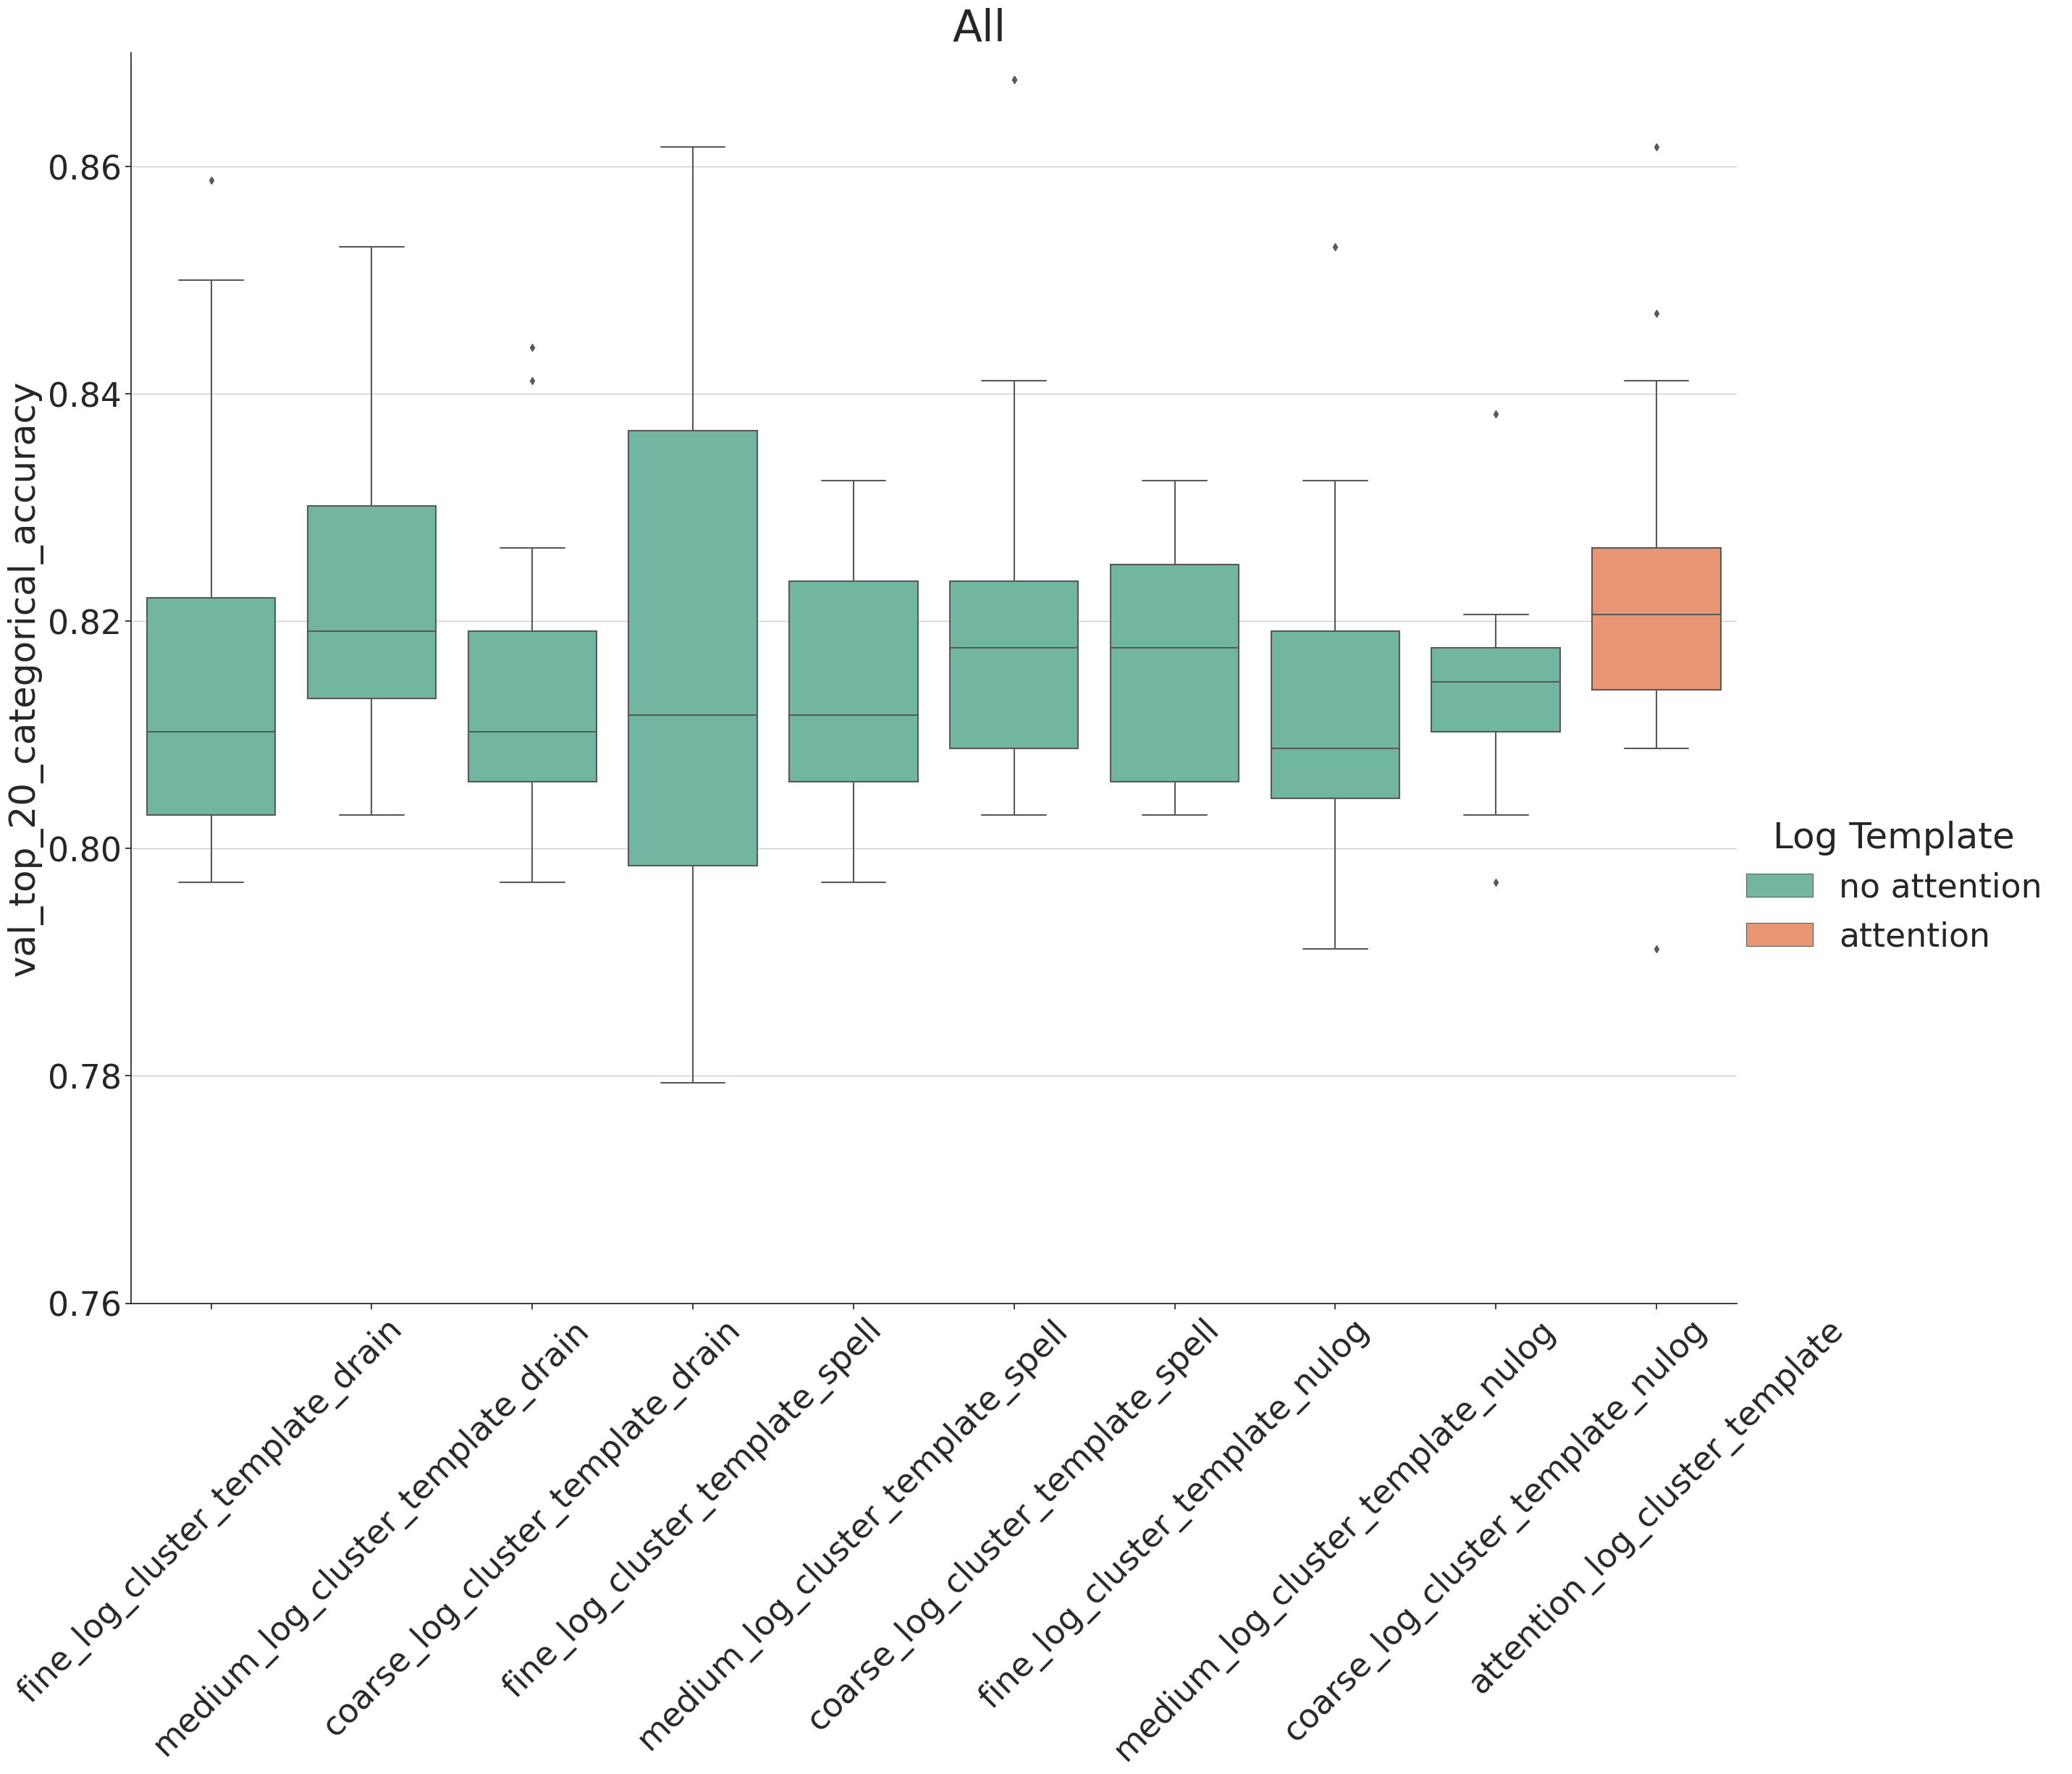

In [91]:
sns.set(font_scale=3)
sns.set_style("ticks",{'axes.grid' : True})
df = huawei_metrics_df.copy()
df["data_params_SequenceConfigx_sequence_column_name"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: {
    "": "attention_log_cluster_template"
}.get(x, x))
df["Log Template"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: "attention" if "attention" in x else "no attention")
g = sns.catplot(
    data=df[
        df["data_params_SequenceConfigy_sequence_column_name"].apply(lambda x: x == "attributes")
        & df["data_tags_model_type"].apply(lambda x: x == "simple")
        &  df["data_params_ModelConfigbase_hidden_embeddings_trainable"].apply(lambda x: x == "False")
        & df["data_params_HuaweiPreprocessorConfigremove_dates_from_payload"].apply(lambda x: x == "True")
        & df["data_params_ExperimentConfign_epochs"].apply(lambda x: x == "25")
        & df["data_params_HuaweiPreprocessorConfiglog_parser"].apply(lambda x: x == "all")
        ],
    hue="Log Template",
    x="data_params_SequenceConfigx_sequence_column_name",
    y="val_top_20_categorical_accuracy_history_best",
    row="data_params_SequenceConfigy_sequence_column_name",
    order=["fine_log_cluster_template_drain", "medium_log_cluster_template_drain", "coarse_log_cluster_template_drain", "fine_log_cluster_template_spell", "medium_log_cluster_template_spell",
           "coarse_log_cluster_template_spell", "fine_log_cluster_template_nulog", "medium_log_cluster_template_nulog", "coarse_log_cluster_template_nulog", "attention_log_cluster_template"],
    kind="box",
    palette="Set2",
    dodge=False,
    height=20,
    aspect=1.3,
).set_xticklabels(rotation=45).set_titles("").set_axis_labels('', "val_top_20_categorical_accuracy")
plt.ylim(0.76, 0.87)
plt.savefig("all_results.png", dpi=150, bbox_inches="tight")
plt.suptitle("All")
plt.show()

In [103]:
huawei_df = mlflow_helper.huawei_run_df(
    valid_x_columns=["fine_log_cluster_template_drain", "coarse_log_cluster_template_drain", "", 
                     "medium_log_cluster_template_drain",  "fine_log_cluster_template_spell", 
                     "coarse_log_cluster_template_spell", "medium_log_cluster_template_spell",
                    "fine_log_cluster_template_nulog", "coarse_log_cluster_template_nulog", "", 
                     "medium_log_cluster_template_nulog",],
    valid_y_columns=["attributes"],
    include_drain_hierarchy=True,
)
huawei_df = huawei_df[
    huawei_df["data_params_ModelConfigbase_feature_embeddings_trainable"].astype(str) == "False"
    ]

huawei_df.groupby(by=[
    "data_params_SequenceConfigx_sequence_column_name",
    "data_params_SequenceConfigy_sequence_column_name",
    "data_tags_model_type",
]).agg({
    "info_run_id": len
})

info_run_id
data_params_SequenceConfigx_sequence_column_name data_params_SequenceConfigy_sequence_column_name data_tags_model_type             
                                                 attributes                                       gram_logs                      15
                                                                                                  simple                         40
coarse_log_cluster_template_drain                attributes                                       gram_logs                       3
                                                                                                  simple                         16
coarse_log_cluster_template_nulog                attributes                                       gram_logs                       3
                                                                                                  simple                         15
coarse_log_cluster_template_spell                attributes                                       gram_logs                       3
                                                                                                  simple                         15
fine_log_cluster_template_drain                  attributes                                       gram_logs                       3
                                                                                                  simple                         16
fine_log_cluster_template_nulog                  attributes                                       gram_logs                       3
                                                                                                  simple                         16
fine_log_cluster_template_spell                  attributes                                       gram_logs                       3
                                                                                                  simple                         15
medium_log_cluster_template_drain                attributes                                       gram_logs                       3
                                                                                                  simple                         16
medium_log_cluster_template_nulog                attributes                                       gram_logs                       3
                                                                                                  simple                         15
medium_log_cluster_template_spell                attributes                                       gram_logs                       3
                                                                                                  simple                         15

In [104]:
huawei_metrics_df = mlflow_helper.load_best_metrics_for_ids(set(huawei_df["info_run_id"]))

Querying metrics for runs: 100%|██████████| 221/221 [00:13<00:00, 16.72it/s]


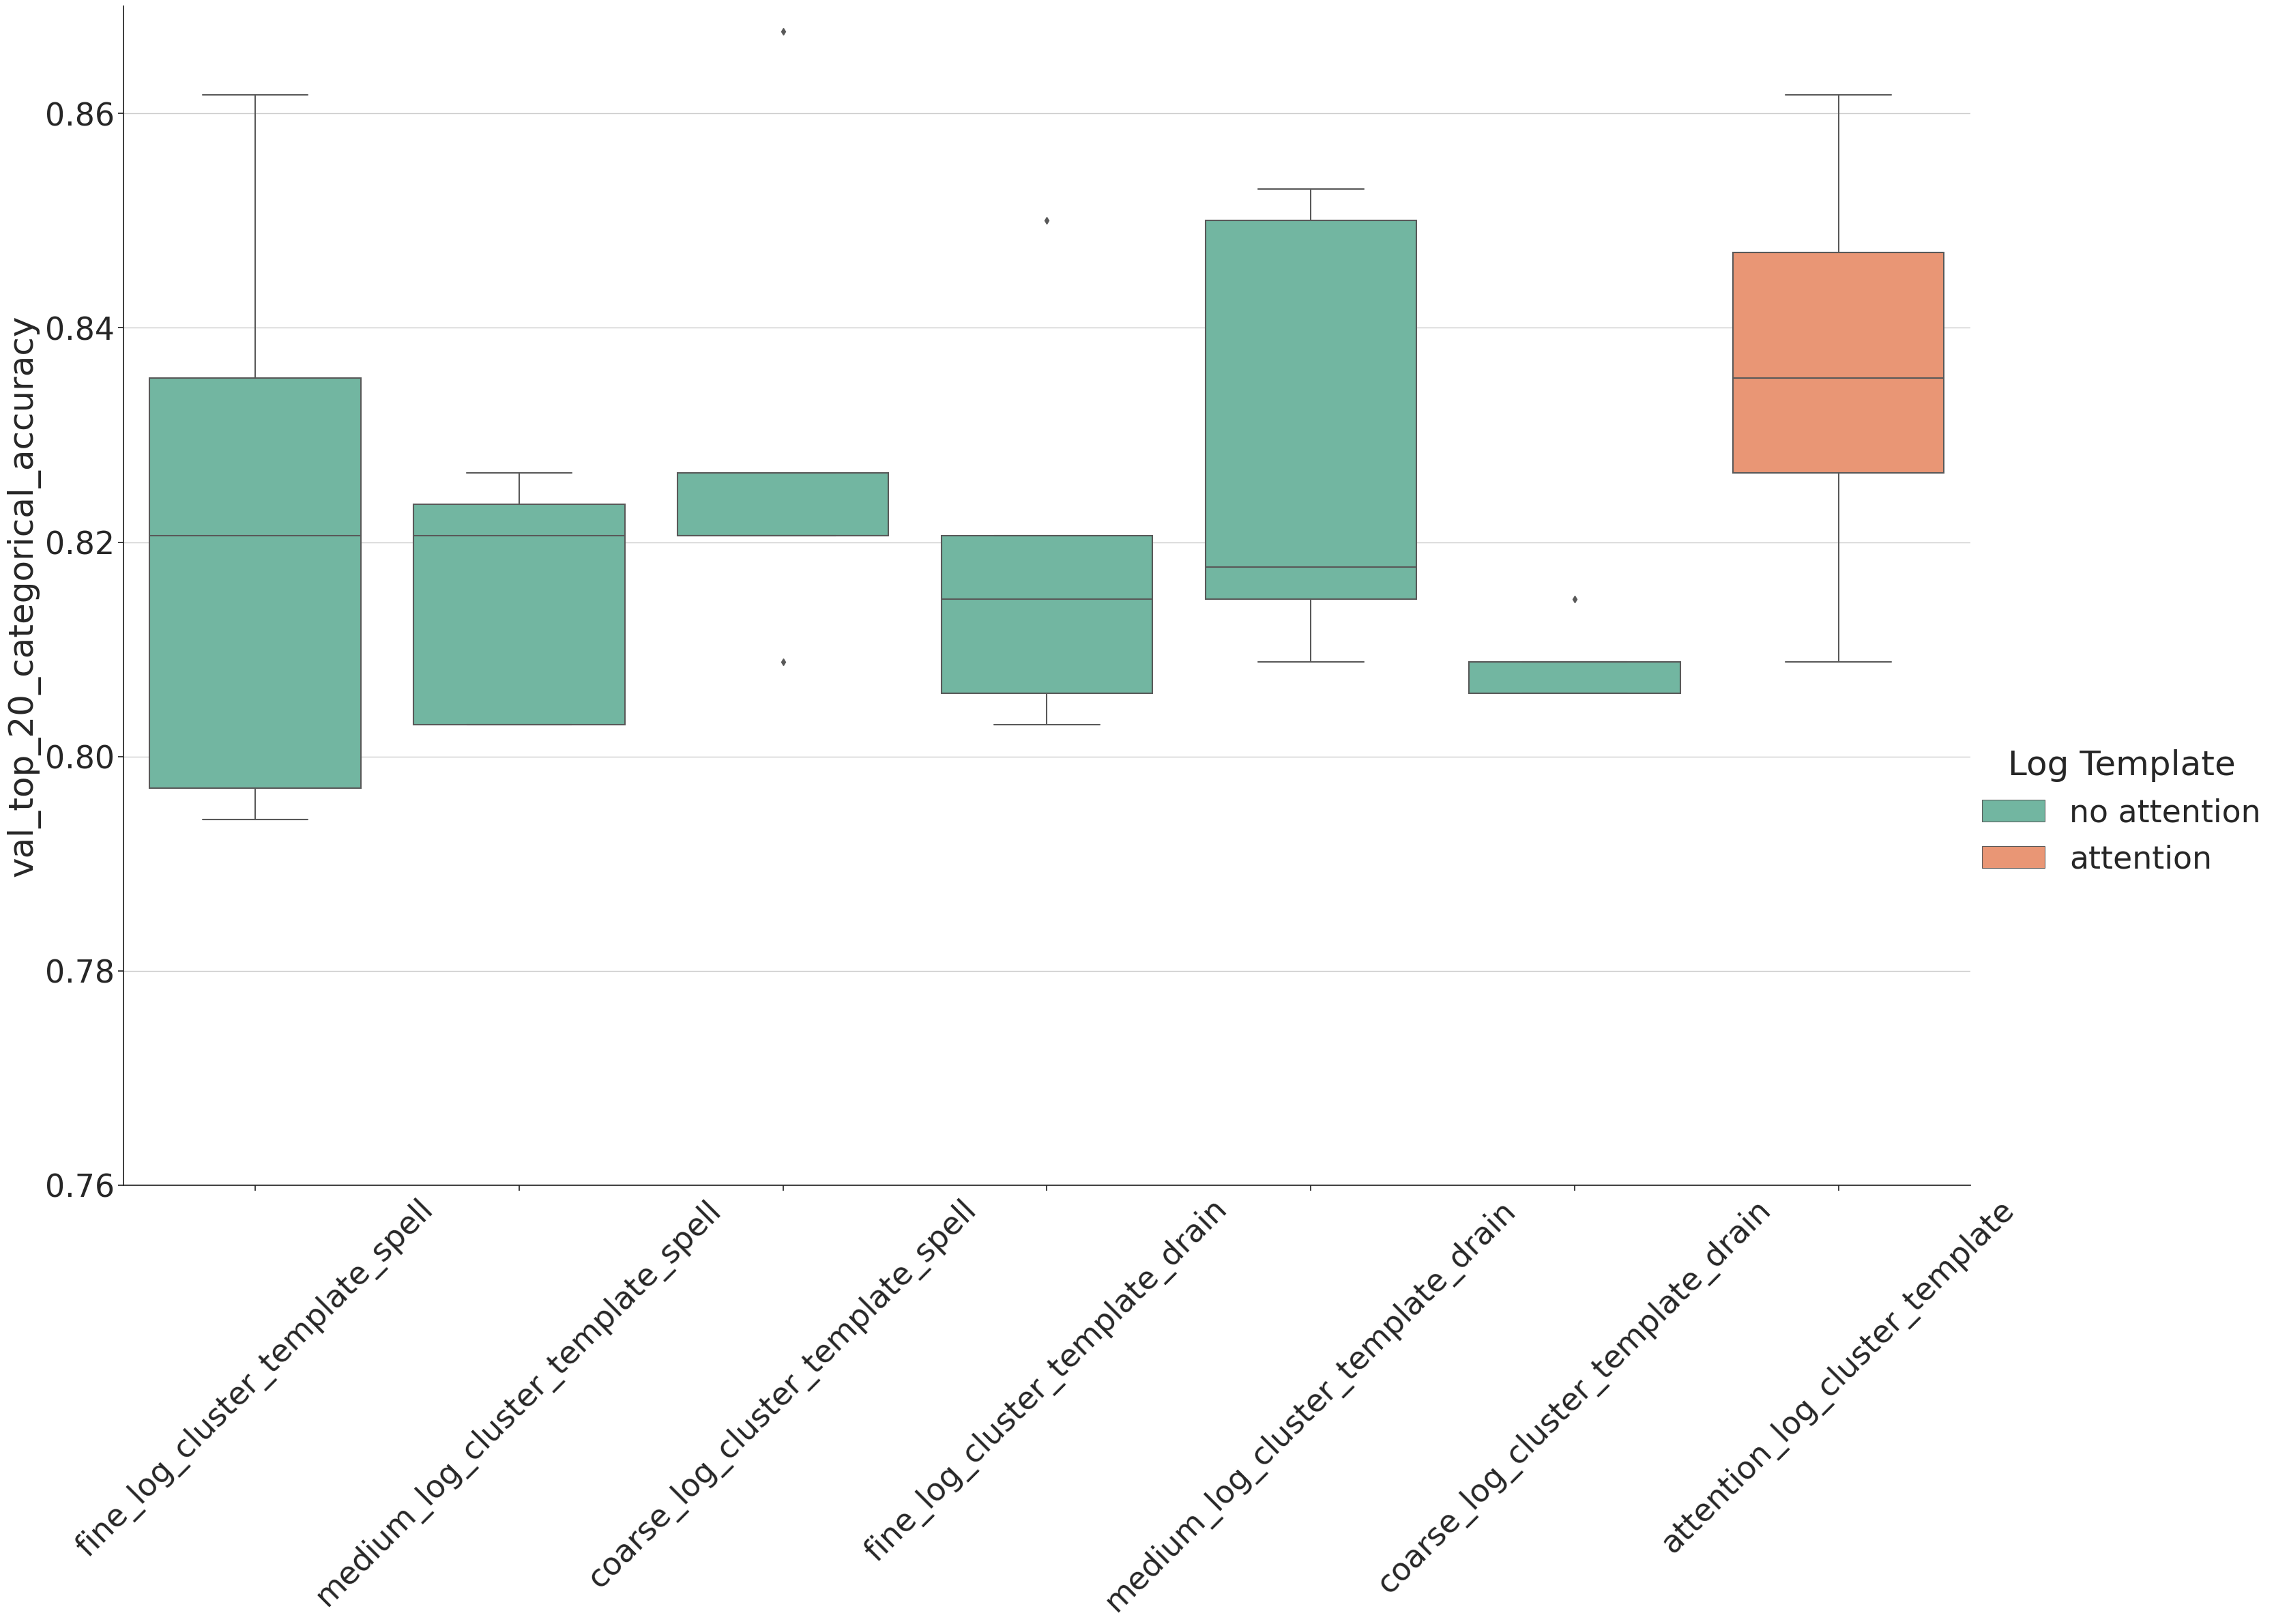

In [107]:
#sns.set(font_scale=4)
df = huawei_metrics_df.copy()
df["data_params_SequenceConfigx_sequence_column_name"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: {
    "": "attention_log_cluster_template"
}.get(x, x))
df["Log Template"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: "attention" if "attention" in x else "no attention")
g = sns.catplot(
    data=df[
        df["data_params_SequenceConfigy_sequence_column_name"].apply(lambda x: x == "attributes")
        & df["data_tags_model_type"].apply(lambda x: x == "simple")
        & df["data_params_HuaweiPreprocessorConfigremove_dates_from_payload"].apply(lambda x: x == "True")
        & df["data_params_HuaweiPreprocessorConfigparser_combination"].apply(lambda x: x == "drain+spell")
        & df["data_params_HuaweiPreprocessorConfiglog_parser"].apply(lambda x: x == "all")
        ],
    hue="Log Template",
    x="data_params_SequenceConfigx_sequence_column_name",
    y="val_top_20_categorical_accuracy_history_best",
    row="data_params_SequenceConfigy_sequence_column_name",
    order=["fine_log_cluster_template_spell", "medium_log_cluster_template_spell", 
           "coarse_log_cluster_template_spell", "fine_log_cluster_template_drain", 
           "medium_log_cluster_template_drain", "coarse_log_cluster_template_drain", 
           "attention_log_cluster_template"],
    kind="box",
    palette="Set2",
    dodge=False,
    height=20,
    aspect=1.5,
).set_xticklabels(rotation=45).set_titles("").set_axis_labels('', "val_top_20_categorical_accuracy")
plt.savefig("nulog+spell.png", dpi=120, bbox_inches="tight")
plt.ylim(0.76, 0.87)
plt.show()

In [112]:
df = huawei_metrics_df.copy()
df["data_params_SequenceConfigx_sequence_column_name"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: {
    "": "attention_log_cluster_template"
}.get(x, x))
df = df[
        df["data_params_SequenceConfigy_sequence_column_name"].apply(lambda x: x == "attributes")
        & df["data_tags_model_type"].apply(lambda x: x == "simple")
        & df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: x == "attention_log_cluster_template")
        & df["data_params_HuaweiPreprocessorConfigremove_dates_from_payload"].apply(lambda x: x == "True")
        & df["data_params_HuaweiPreprocessorConfigparser_combination"].apply(lambda x: x == "drain+spell")
        & df["data_params_HuaweiPreprocessorConfiglog_parser"].apply(lambda x: x == "all")
        ]
df["data_metrics_val_top_20_categorical_accuracy"].median()

0.8176470398902893

In [6]:
huawei_df = mlflow_helper.huawei_run_df(
    valid_x_columns=["fine_log_cluster_template_drain", "coarse_log_cluster_template_drain", "", "medium_log_cluster_template_drain",  "fine_log_cluster_template_nulog", "coarse_log_cluster_template_nulog", "medium_log_cluster_template_nulog"],
    valid_y_columns=["attributes"],
    include_drain_hierarchy=True,
)
huawei_df = huawei_df[
    huawei_df["data_params_ModelConfigbase_feature_embeddings_trainable"].astype(str) == "False"
    ]

huawei_df.groupby(by=[
    "data_params_SequenceConfigx_sequence_column_name",
    "data_params_SequenceConfigy_sequence_column_name",
    "data_tags_model_type",
]).agg({
    "info_run_id": len
})

,,,info_run_id
data_params_SequenceConfigx_sequence_column_name,data_params_SequenceConfigy_sequence_column_name,data_tags_model_type,
,attributes,simple,112
coarse_log_cluster_template_drain,attributes,simple,53
coarse_log_cluster_template_nulog,attributes,simple,50
fine_log_cluster_template_drain,attributes,simple,56
fine_log_cluster_template_nulog,attributes,simple,50
medium_log_cluster_template_drain,attributes,simple,54
medium_log_cluster_template_nulog,attributes,simple,50


In [7]:
huawei_metrics_df = mlflow_helper.load_best_metrics_for_ids(set(huawei_df["info_run_id"]))

Querying metrics for runs: 100%|██████████| 425/425 [00:25<00:00, 16.67it/s]


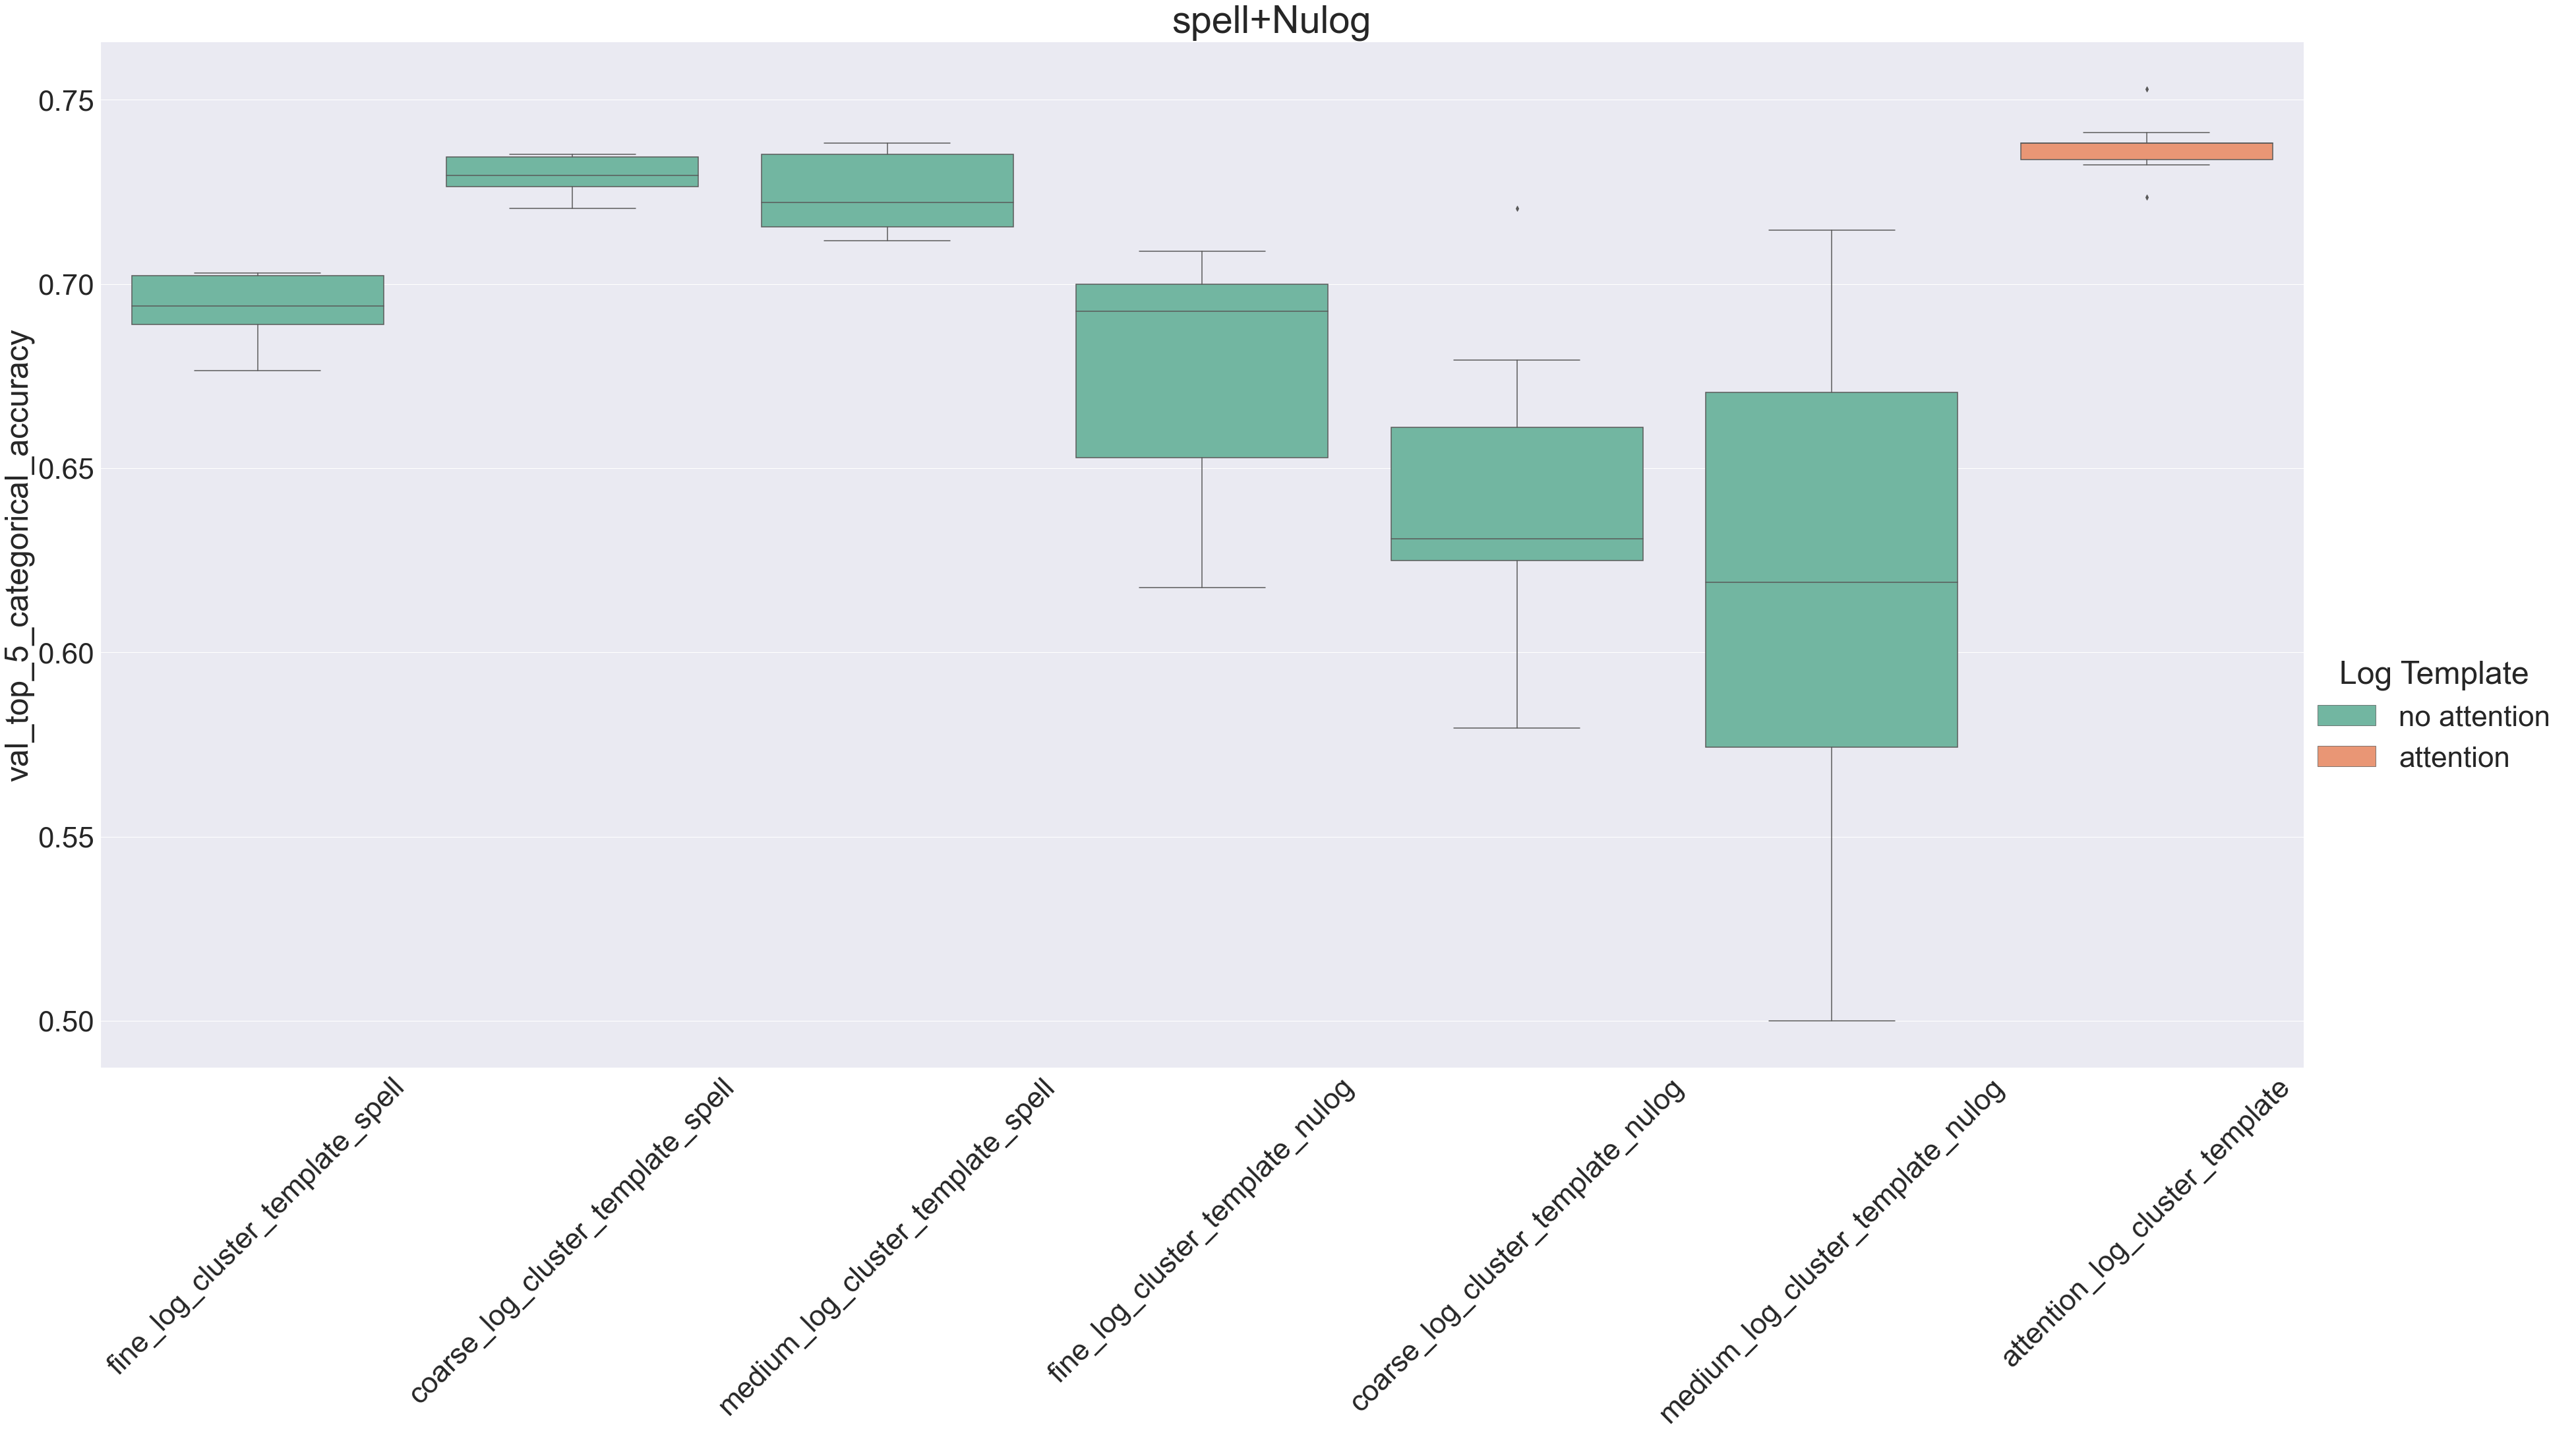

In [15]:
sns.set(font_scale=4)
df = huawei_metrics_df.copy()
df["data_params_SequenceConfigx_sequence_column_name"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: {
    "": "attention_log_cluster_template"
}.get(x, x))
df["Log Template"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: "attention" if "attention" in x else "no attention")
g = sns.catplot(
    data=df[
        df["data_params_SequenceConfigy_sequence_column_name"].apply(lambda x: x == "attributes")
        & df["data_tags_model_type"].apply(lambda x: x == "simple")
        &  df["data_params_ModelConfigbase_hidden_embeddings_trainable"].apply(lambda x: x == "False")
        & df["data_params_HuaweiPreprocessorConfigremove_dates_from_payload"].apply(lambda x: x == "True")
        & df["data_params_ExperimentConfign_epochs"].apply(lambda x: x == "25")
        & df["data_params_HuaweiPreprocessorConfigparser_combination"].apply(lambda x: x == "spell+nulog")
        #& df["data_params_HuaweiPreprocessorConfiglog_parser"].apply(lambda x: x == "nulog")
        ],
    hue="Log Template",
    x="data_params_SequenceConfigx_sequence_column_name",
    y="val_top_5_categorical_accuracy_history_best",
    row="data_params_SequenceConfigy_sequence_column_name",
    order=["fine_log_cluster_template_spell", "coarse_log_cluster_template_spell", "medium_log_cluster_template_spell", "fine_log_cluster_template_nulog", "coarse_log_cluster_template_nulog", "medium_log_cluster_template_nulog", "attention_log_cluster_template"],
    kind="box",
    palette="Set2",
    dodge=False,
    height=25,
    aspect=2,
).set_xticklabels(rotation=45).set_titles("").set_axis_labels('', "val_top_5_categorical_accuracy")
plt.savefig("spell+nulog.png", dpi=120, bbox_inches="tight")
plt.suptitle("spell+Nulog")
plt.show()

In [16]:
df = pd.read_pickle("../all_logs.pkl")
df["all_events"]

0    [[Hostname#wally113, coarse_log_cluster_templa...
Name: all_events, dtype: object

# Timestamp Comparison

In [25]:
mlflow_helper = MlflowHelper(pkl_file=Path("mlflow_run_df.pkl"), experiment_id="750197874267225516")
mlflow_helper.query_valid_runs(pkl_file=Path("mlflow_run_df.pkl"))

huawei_df = mlflow_helper.huawei_run_df(
    valid_x_columns=["fine_log_cluster_template", "coarse_log_cluster_template", "", "medium_log_cluster_template"],
    valid_y_columns=["attributes"],
    include_drain_hierarchy=False,
)
huawei_df = huawei_df[
    huawei_df["data_params_ModelConfigbase_feature_embeddings_trainable"].astype(str) == "False"
    ]

huawei_df.groupby(by=[
    "data_params_SequenceConfigx_sequence_column_name",
    "data_params_SequenceConfigy_sequence_column_name",
    "data_tags_model_type",
]).agg({
    "info_run_id": len
})

Querying data per run...: 0it [00:00, ?it/s]


Queried 0 runs from MLFlow for mimic


Querying data per run...: 100%|██████████| 108/108 [00:00<00:00, 134.98it/s]


Queried 108 runs from MLFlow for huawei_logs


Querying data per run...: 0it [00:00, ?it/s]


Queried 108 runs from MLFlow for hdfs


Querying data per run...: 0it [00:00, ?it/s]

Queried 108 runs from MLFlow for tbird_logs


info_run_id
data_params_SequenceConfigx_sequence_column_name data_params_SequenceConfigy_sequence_column_name data_tags_model_type             
                                                 attributes                                       gram_logs                       9
                                                                                                  simple                         18
coarse_log_cluster_template                      attributes                                       gram_logs                       9
                                                                                                  simple                         18
fine_log_cluster_template                        attributes                                       gram_logs                       9
                                                                                                  simple                         18
medium_log_cluster_template                      attributes                                       gram_logs                       9
                                                                                                  simple                         18

In [26]:
huawei_metrics_df = mlflow_helper.load_best_metrics_for_ids(set(huawei_df["info_run_id"]))

Querying metrics for runs: 100%|██████████| 108/108 [00:06<00:00, 16.48it/s]


In [6]:
huawei_metrics_df["data_params_HuaweiPreprocessorConfigremove_dates_from_payload"]

0      False
1       True
2      False
3      False
4       True
       ...  
103    False
104    False
105     True
106    False
107     True
Name: data_params_HuaweiPreprocessorConfigremove_dates_from_payload, Length: 108, dtype: object

0          With Timestamps 2k
1      Without Timestamps 20k
2         With Timestamps 20k
3       Without Timestamps 2k
4         With Timestamps 20k
                ...          
103       With Timestamps 20k
104       With Timestamps 20k
105      With Timestamps 200k
106     Without Timestamps 2k
107        With Timestamps 2k
Name: Timestamps, Length: 108, dtype: object


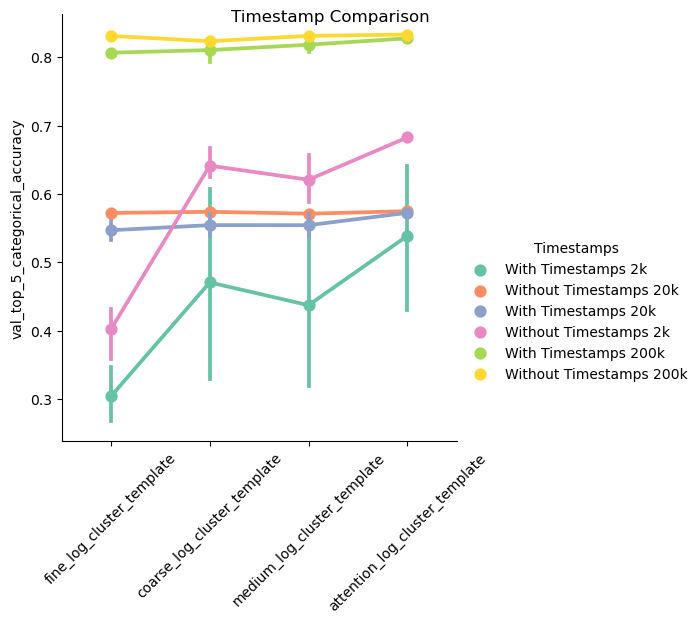

In [27]:
df = huawei_metrics_df.copy()
df["data_params_SequenceConfigx_sequence_column_name"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: {
    "": "attention_log_cluster_template"
}.get(x, x))

# define conditions and choices
conditions = [
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == "False") & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_2000.csv'),
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == "False") & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_5000.csv'),
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == "False") & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_20000.csv'),
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == "False") & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_200000.csv'),
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == "True") & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_2000.csv'),
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == "True") & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_5000.csv'),
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == "True") & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_20000.csv'), 
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == "True") & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_200000.csv'),
]

choices = [
    'With Timestamps 2k',
    'With Timestamps 5k',
    'With Timestamps 20k',
    'With Timestamps 200k',
    'Without Timestamps 2k',
    'Without Timestamps 5k',
    'Without Timestamps 20k',
    'Without Timestamps 200k',
]

# create new column
df["Timestamps"] = np.select(conditions, choices, default="Unknown")
print(df["Timestamps"])


#df["Timestamps"] = df["data_params_HuaweiPreprocessorConfigremove_dates_from_payload"].apply(lambda x: "With Timestamps" if x=="False" else "Without Timestamps")
g = sns.catplot(
    data=df,
    hue="Timestamps",
    x="data_params_SequenceConfigx_sequence_column_name",
    y="val_top_5_categorical_accuracy_history_best",
    order=["fine_log_cluster_template", "coarse_log_cluster_template", "medium_log_cluster_template", "attention_log_cluster_template"],
    kind="point",
    palette="Set2",
    dodge=False,
).set_xticklabels(rotation=45).set_titles("").set_axis_labels('', "val_top_5_categorical_accuracy")
plt.savefig("timestamps_comparison.png", dpi=120, bbox_inches="tight")
plt.suptitle("Timestamp Comparison")
plt.show()

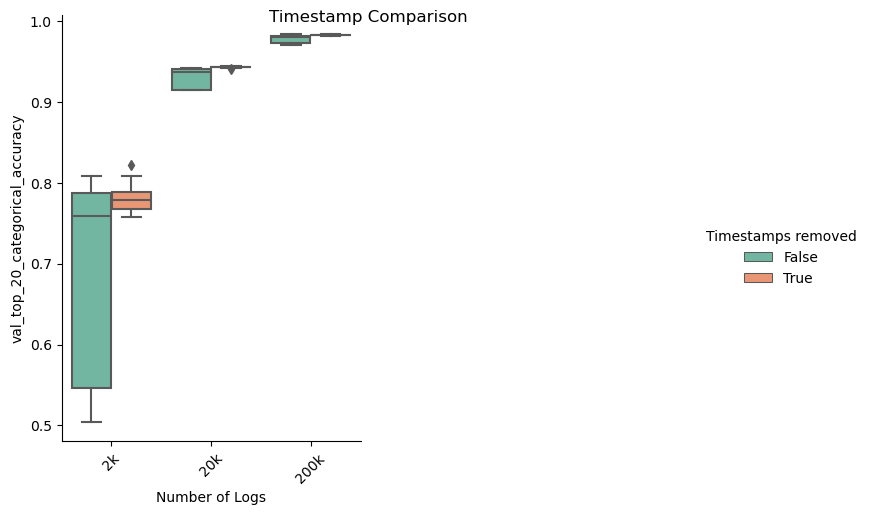

In [28]:
df = huawei_metrics_df.copy()
df["data_params_SequenceConfigx_sequence_column_name"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: {
    "": "attention_log_cluster_template"
}.get(x, x))

# define conditions and choices
conditions = [
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == "False") & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_2000.csv'),
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == "False") & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_20000.csv'),
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == "False") & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_200000.csv'),
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == "True") & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_2000.csv'),
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == "True") & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_20000.csv'), 
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == "True") & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_200000.csv'),
]

choices = [
    'With Timestamps 2k',
    'With Timestamps 20k',
    'With Timestamps 200k',
    'Without Timestamps 2k',
    'Without Timestamps 20k',
    'Without Timestamps 200k',
]

# create new column
df["Timestamps"] = np.select(conditions, choices, default="Unknown")


#df["Timestamps"] = df["data_params_HuaweiPreprocessorConfigremove_dates_from_payload"].apply(lambda x: "With Timestamps" if x=="False" else "Without Timestamps")
g = sns.catplot(
    data=df,
    hue="data_params_HuaweiPreprocessorConfigremove_dates_from_payload",
    x="data_params_HuaweiPreprocessorConfigaggregated_log_file",
    y="val_top_20_categorical_accuracy_history_best",
    order=["data/logs_aggregated_concurrent_2000.csv", "data/logs_aggregated_concurrent_20000.csv", "data/logs_aggregated_concurrent_200000.csv"],
    kind="box",
    palette="Set2",
    dodge=True,
).set_xticklabels(rotation=45).set_titles("").set_axis_labels('', "val_top_20_categorical_accuracy")
g.set(xlabel='Number of Logs', xticklabels=['2k', '20k', '200k'])
g._legend.set_title("Timestamps removed")
plt.savefig("timestamps_comparison.png", dpi=120, bbox_inches="tight")
plt.suptitle("Timestamp Comparison")
plt.show()

AttributeError: 'MlflowClient' object has no attribute 'list_experiments'

In [67]:
df2.merge(df2, left_on="data_params_HuaweiPreprocessorConfigremove_dates_from_payload", right_on="data_params_HuaweiPreprocessorConfigaggregated_log_file")

,val_loss_history_best_x,val_loss_times_best_x,val_top_5_categorical_accuracy_p2_history_best_x,val_top_5_categorical_accuracy_p2_times_best_x,val_categorical_accuracy_history_best_x,val_categorical_accuracy_times_best_x,top_20_categorical_accuracy_p2_history_best_x,top_20_categorical_accuracy_p2_times_best_x,top_5_categorical_accuracy_p4_history_best_x,top_5_categorical_accuracy_p4_times_best_x,...,data_tags_mlflow.source.git.commit_y,info_artifact_uri_y,info_end_time_y,info_experiment_id_y,info_lifecycle_stage_y,info_run_name_y,info_run_uuid_y,info_start_time_y,info_status_y,info_user_id_y


In [69]:
df2['merged_column'] = df2['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'].combine_first(df2['data_params_HuaweiPreprocessorConfigaggregated_log_file'])

In [70]:
df2['merged_column']

0      True
1     False
2     False
3      True
4     False
      ...  
91    False
92     True
93     True
94     True
95     True
Name: merged_column, Length: 96, dtype: object

In [72]:
df_merged = pd.merge(df, df, on=['data_params_HuaweiPreprocessorConfigremove_dates_from_payload', 'data_params_HuaweiPreprocessorConfigaggregated_log_file'], how='inner')

In [75]:
df_merged

,val_loss_history_best_x,val_loss_times_best_x,val_top_5_categorical_accuracy_p2_history_best_x,val_top_5_categorical_accuracy_p2_times_best_x,val_categorical_accuracy_history_best_x,val_categorical_accuracy_times_best_x,top_20_categorical_accuracy_p2_history_best_x,top_20_categorical_accuracy_p2_times_best_x,top_5_categorical_accuracy_p4_history_best_x,top_5_categorical_accuracy_p4_times_best_x,...,info_artifact_uri_y,info_end_time_y,info_experiment_id_y,info_lifecycle_stage_y,info_run_name_y,info_run_uuid_y,info_start_time_y,info_status_y,info_user_id_y,Timestamps_y
0,0.051120,1678150005159,0.068493,1678150005164,0.225513,1678150005159,0.778042,1678150005157,0.797026,1678150005150,...,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.678150e+12,222398694951089913,active,gentle-stoat-188,6f8067a299784d1ea94aaa6dda2fa13c,1.678149e+12,FINISHED,pacev,Without Timestamps
1,0.051120,1678150005159,0.068493,1678150005164,0.225513,1678150005159,0.778042,1678150005157,0.797026,1678150005150,...,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.678145e+12,222398694951089913,active,auspicious-lark-148,8aefce1855ca452baff1e24de935c0f4,1.678144e+12,FINISHED,pacev,Without Timestamps
2,0.051120,1678150005159,0.068493,1678150005164,0.225513,1678150005159,0.778042,1678150005157,0.797026,1678150005150,...,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.678182e+12,222398694951089913,active,dazzling-perch-149,0e1ac60dd367491fa806cf90dcfd61a4,1.678181e+12,FINISHED,pacev,Without Timestamps
3,0.051120,1678150005159,0.068493,1678150005164,0.225513,1678150005159,0.778042,1678150005157,0.797026,1678150005150,...,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.678141e+12,222398694951089913,active,intelligent-snail-47,36eba885bd5f48b9a88b308290a6df22,1.678140e+12,FINISHED,pacev,Without Timestamps
4,0.051120,1678150005159,0.068493,1678150005164,0.225513,1678150005159,0.778042,1678150005157,0.797026,1678150005150,...,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.678149e+12,222398694951089913,active,dapper-goat-924,32334a4ceed7479cbe67a27bc7f4457c,1.678148e+12,FINISHED,pacev,Without Timestamps
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,0.082212,1678119199071,0.111111,1678119199076,0.215568,1678119199072,0.546763,1678119199070,0.615608,1678119199063,...,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.678121e+12,222398694951089913,active,bald-smelt-500,39e1abdb436a400a815ae1c3694746a3,1.678121e+12,FINISHED,pacev,Without Timestamps
1148,0.082212,1678119199071,0.111111,1678119199076,0.215568,1678119199072,0.546763,1678119199070,0.615608,1678119199063,...,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.678121e+12,222398694951089913,active,adaptable-boar-539,14f647c6cb42439ca4e2d94c30d93ec1,1.678121e+12,FINISHED,pacev,Without Timestamps
1149,0.082212,1678119199071,0.111111,1678119199076,0.215568,1678119199072,0.546763,1678119199070,0.615608,1678119199063,...,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.678119e+12,222398694951089913,active,trusting-bear-720,b11b8b56ccef48829d87bf96deb5e0e1,1.678119e+12,FINISHED,pacev,Without Timestamps
1150,0.082212,1678119199071,0.111111,1678119199076,0.215568,1678119199072,0.546763,1678119199070,0.615608,1678119199063,...,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.678120e+12,222398694951089913,active,popular-dove-737,d37b0bd6ed3d4cd2bd7ecfc13ef0b33a,1.678120e+12,FINISHED,pacev,Without Timestamps


In [88]:
conditions = [
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == False) & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_2000.csv'),
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == False) & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_5000.csv'),
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == False) & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_20000.csv'),
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == False) & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_200000.csv'),
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == True) & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_2000.csv'),
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == True) & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_5000.csv'),
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == True) & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_20000.csv'), 
    (df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == True) & (df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_200000.csv'),
]

choices = [
    'With Timestamps 2k',
    'With Timestamps 5k',
    'With Timestamps 20k',
    'With Timestamps 200k'
    'Without Timestamps 2k',
    'Without Timestamps 5k',
    'Without Timestamps 20k',
    'Without Timestamps 200k',
]
len(choices)

7

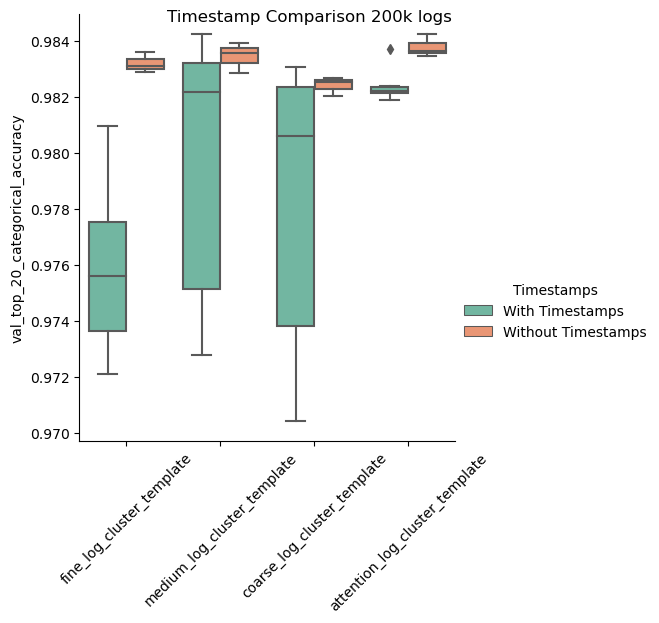

In [12]:
df = huawei_metrics_df.copy()
df["data_params_SequenceConfigx_sequence_column_name"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: {
    "": "attention_log_cluster_template"
}.get(x, x))
df = df.query("data_params_HuaweiPreprocessorConfigaggregated_log_file == 'data/logs_aggregated_concurrent_200000.csv'")
df["Timestamps"] = df["data_params_HuaweiPreprocessorConfigremove_dates_from_payload"].apply(lambda x: "With Timestamps" if x=="False" else "Without Timestamps")
g = sns.catplot(
    data=df,
    hue="Timestamps",
    x="data_params_SequenceConfigx_sequence_column_name",
    y="val_top_20_categorical_accuracy_history_best",
    order=["fine_log_cluster_template", "medium_log_cluster_template", "coarse_log_cluster_template", "attention_log_cluster_template"],
    kind="box",
    palette="Set2",
    dodge=True,
).set_xticklabels(rotation=45).set_titles("").set_axis_labels('', "val_top_20_categorical_accuracy")
plt.savefig("timestamps_comparison.png", dpi=120, bbox_inches="tight")
plt.suptitle("Timestamp Comparison 200k logs")
plt.show()

# HDFS

# All Parsers

In [113]:
mlflow_helper = MlflowHelper(pkl_file=Path("mlflow_run_df.pkl"), experiment_id="860193396465686391")
mlflow_helper.query_valid_runs(pkl_file=Path("mlflow_run_df.pkl"))

Querying data per run...: 0it [00:00, ?it/s]


Queried 0 runs from MLFlow for mimic


Querying data per run...: 0it [00:00, ?it/s]


Queried 0 runs from MLFlow for huawei_logs


Querying data per run...: 100%|██████████| 126/126 [00:01<00:00, 104.06it/s]


Queried 126 runs from MLFlow for hdfs


Querying data per run...: 100%|██████████| 10/10 [00:00<00:00, 150.87it/s]

Queried 136 runs from MLFlow for tbird_logs


In [178]:
hdfs_df = mlflow_helper.hdfs_run_df(
    valid_x_columns=["fine_log_cluster_template_drain", "coarse_log_cluster_template_drain", "", "medium_log_cluster_template_drain", "fine_log_cluster_template_spell", "coarse_log_cluster_template_spell",
                     "medium_log_cluster_template_spell", "fine_log_cluster_template_nulog", "coarse_log_cluster_template_nulog", "medium_log_cluster_template_nulog"],
    valid_y_columns=["attributes"],
)

hdfs_df.groupby(by=[
    "data_params_SequenceConfigx_sequence_column_name",
    "data_params_SequenceConfigy_sequence_column_name",
    "data_tags_model_type",
]).agg({
    "info_run_id": len
})

,,,info_run_id
data_params_SequenceConfigx_sequence_column_name,data_params_SequenceConfigy_sequence_column_name,data_tags_model_type,
,attributes,simple,24
coarse_log_cluster_template_drain,attributes,simple,3
coarse_log_cluster_template_nulog,attributes,simple,11
coarse_log_cluster_template_spell,attributes,simple,11
fine_log_cluster_template_drain,attributes,simple,3
fine_log_cluster_template_nulog,attributes,simple,11
fine_log_cluster_template_spell,attributes,simple,11
medium_log_cluster_template_drain,attributes,simple,3
medium_log_cluster_template_nulog,attributes,simple,11


In [179]:
hdfs_metrics_df = mlflow_helper.load_best_metrics_for_ids(set(hdfs_df["info_run_id"]))

Querying metrics for runs: 100%|██████████| 99/99 [00:05<00:00, 16.92it/s]


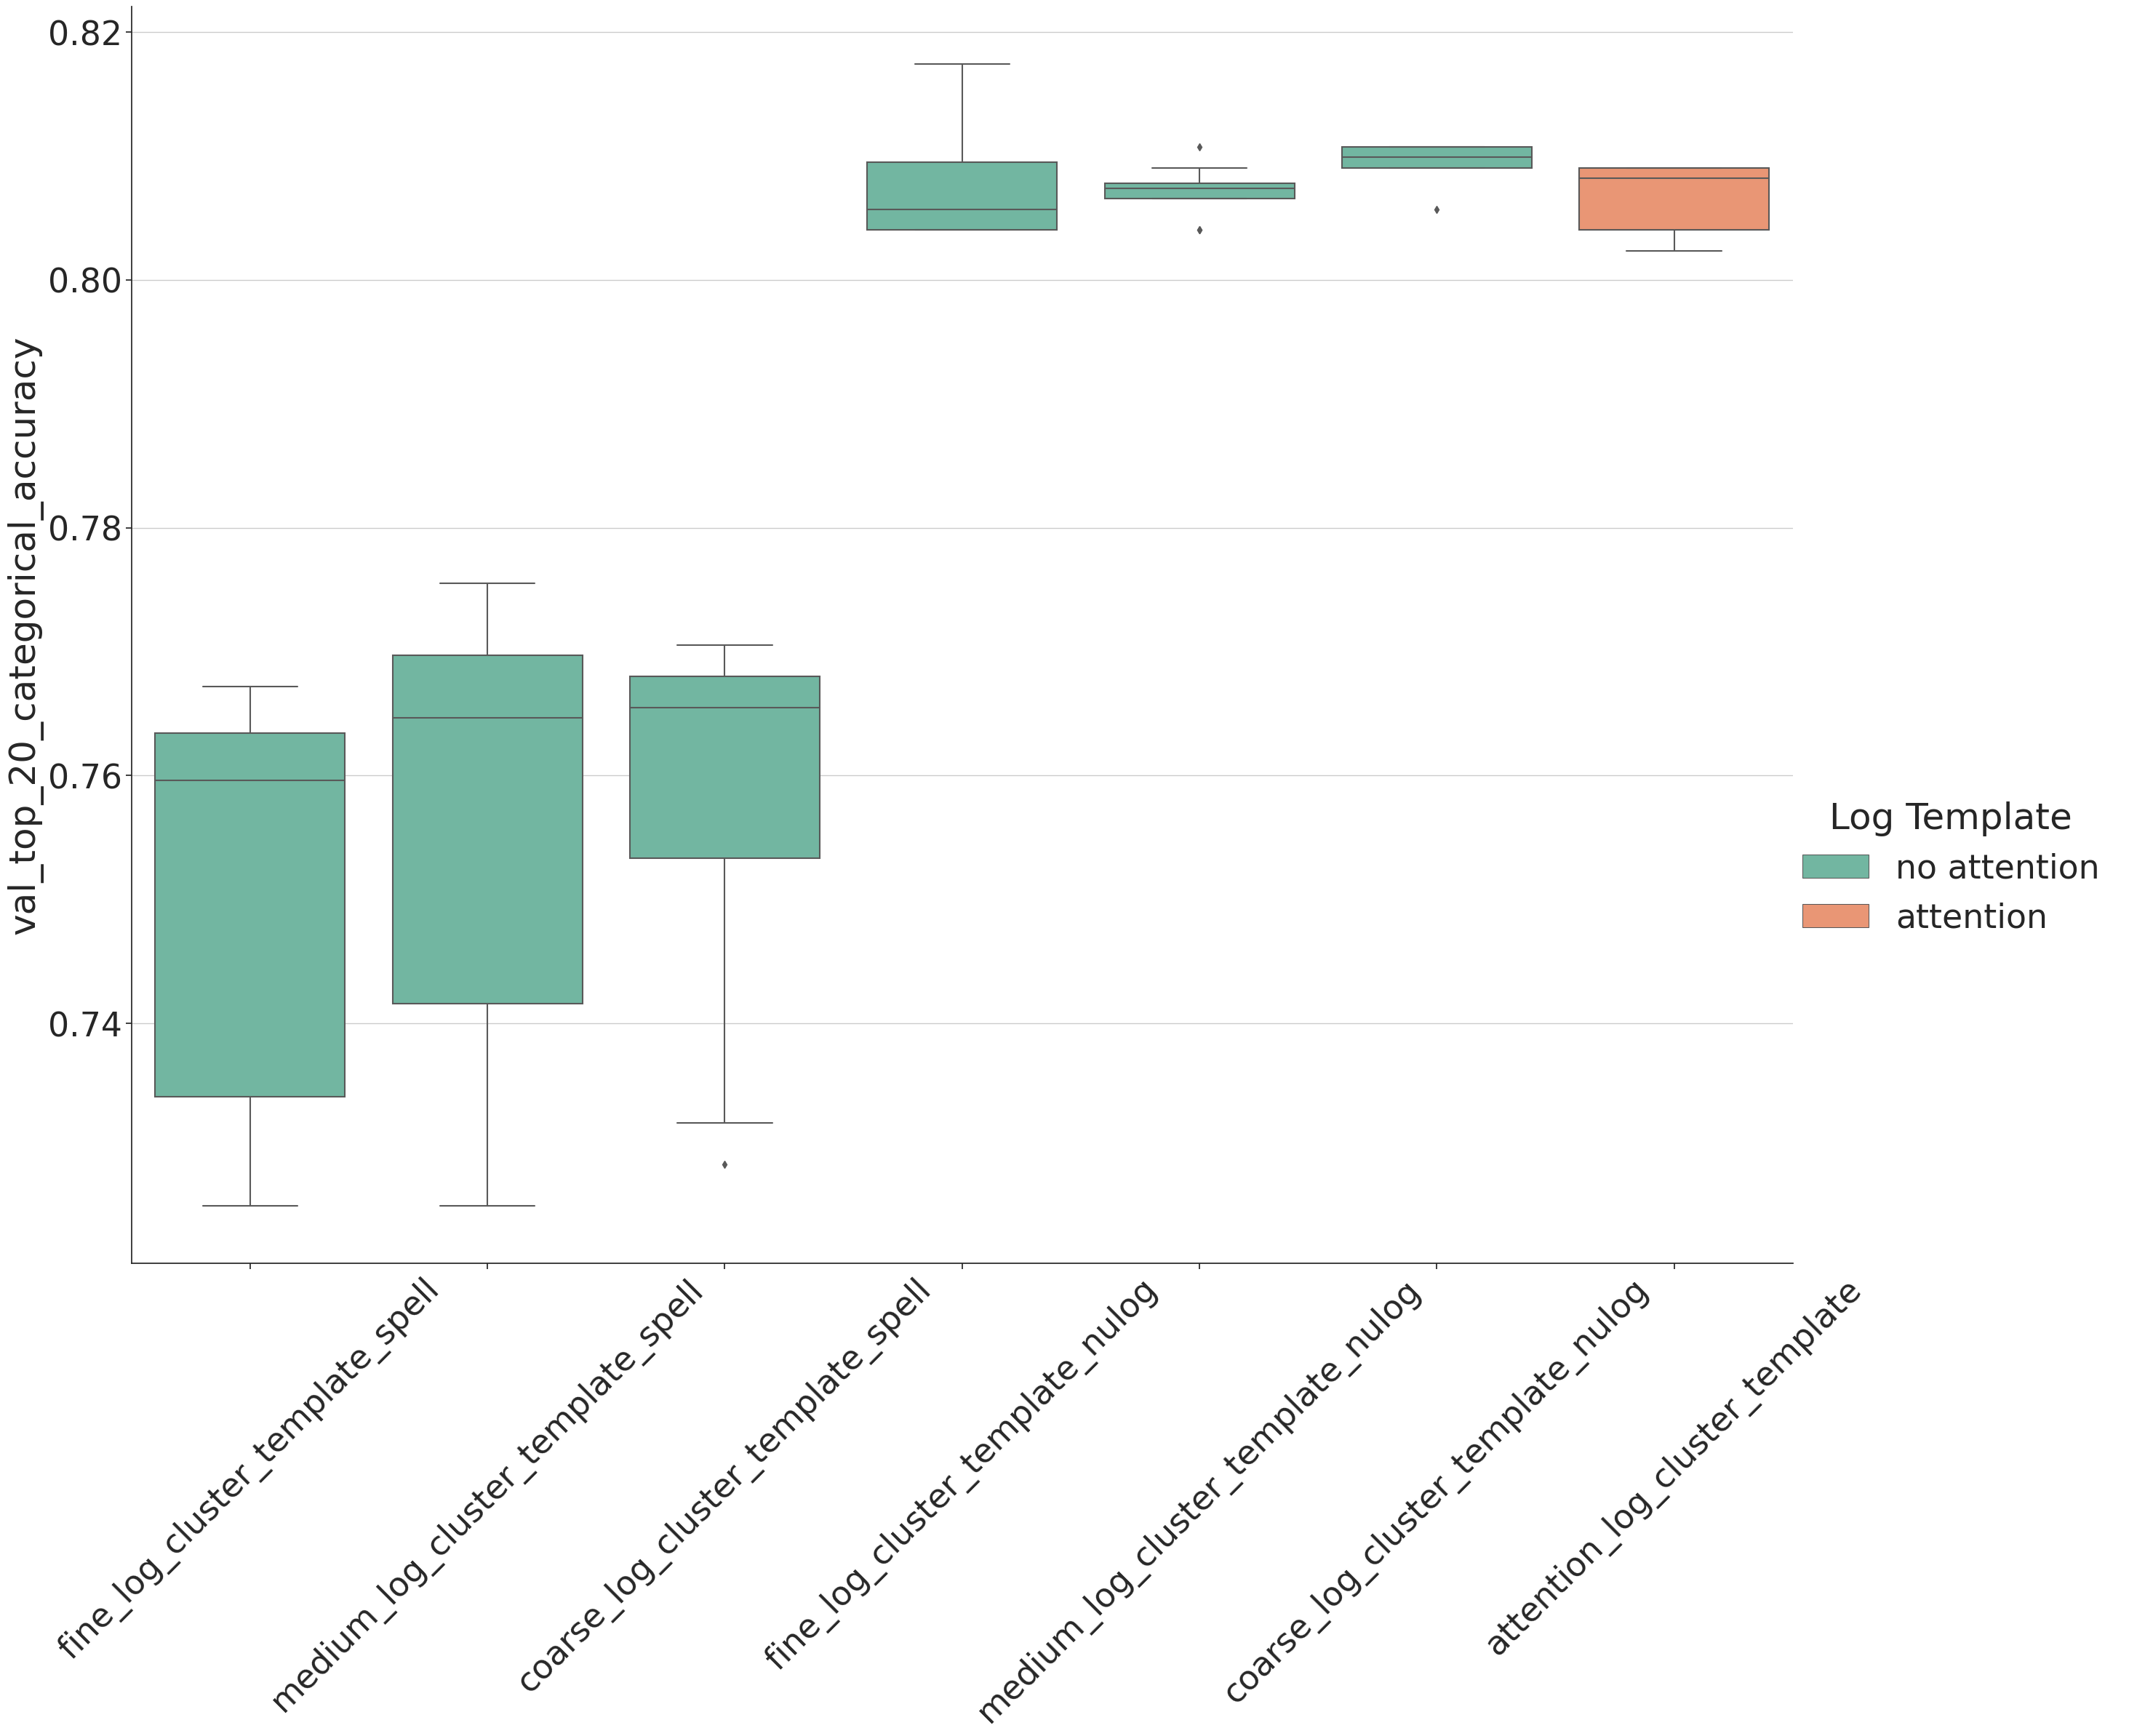

In [186]:
sns.set(font_scale=3)
sns.set_style("ticks",{'axes.grid' : True})
custom_palette = {"attention": sns.color_palette("Set2")[1], "no attention": sns.color_palette("Set2")[0]}

df = hdfs_metrics_df.copy()
df["data_params_SequenceConfigx_sequence_column_name"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: {
    "": "attention_log_cluster_template"
}.get(x, x))
df["Log Template"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: "attention" if "attention" in x else "no attention")
g = sns.catplot(
    data=df[
        df["data_params_HDFSPreprocessorConfiglog_parser"].apply(lambda x: x == "all")
       & df["data_params_HDFSPreprocessorConfigparser_combination"].apply(lambda x: x == "SPELL+NULOG")
        ],
    hue="Log Template",
    x="data_params_SequenceConfigx_sequence_column_name",
    y="val_top_10_categorical_accuracy_history_best",
    row="data_params_SequenceConfigy_sequence_column_name",
    order=["fine_log_cluster_template_spell", "medium_log_cluster_template_spell",
           "coarse_log_cluster_template_spell", "fine_log_cluster_template_nulog", "medium_log_cluster_template_nulog", "coarse_log_cluster_template_nulog", "attention_log_cluster_template"],
    kind="box",
    palette=custom_palette,
    dodge=False,
    height=20,
    aspect=1.3,
).set_xticklabels(rotation=45).set_titles("").set_axis_labels('', "val_top_20_categorical_accuracy")
plt.savefig("all_results_HDFS.png", dpi=150, bbox_inches="tight")
#plt.suptitle("ALL Parsers HDFS Top 10")
plt.show()

# Individual Algos HDFS

In [157]:
hdfs_df = mlflow_helper.hdfs_run_df(
    valid_x_columns=["fine_log_cluster_template", "medium_log_cluster_template", "coarse_log_cluster_template", ""],
    valid_y_columns=["attributes"],
)

hdfs_df.groupby(by=[
    "data_params_SequenceConfigx_sequence_column_name",
    "data_params_SequenceConfigy_sequence_column_name",
    "data_tags_model_type",
]).agg({
    "info_run_id": len
})

,,,info_run_id
data_params_SequenceConfigx_sequence_column_name,data_params_SequenceConfigy_sequence_column_name,data_tags_model_type,
,attributes,simple,24
coarse_log_cluster_template,attributes,simple,9
fine_log_cluster_template,attributes,simple,9
medium_log_cluster_template,attributes,simple,9


In [158]:
hdfs_metrics_df = mlflow_helper.load_best_metrics_for_ids(set(hdfs_df["info_run_id"]))

Querying metrics for runs: 100%|██████████| 51/51 [00:03<00:00, 16.91it/s]


In [154]:
df = hdfs_metrics_df.copy()
df["data_params_SequenceConfigx_sequence_column_name"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: {
    "": "attention_log_cluster_template"
}.get(x, x))
df = df[
        df["data_params_SequenceConfigy_sequence_column_name"].apply(lambda x: x == "attributes")
        & df["data_tags_model_type"].apply(lambda x: x == "simple")
        & df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: x == "attention_log_cluster_template")
      #  & df["data_params_HuaweiPreprocessorConfigremove_dates_from_payload"].apply(lambda x: x == "True")
      #  & df["data_params_HuaweiPreprocessorConfigparser_combination"].apply(lambda x: x == "drain+spell")
        & df["data_params_HDFSPreprocessorConfiglog_parser"].apply(lambda x: x == "all")
        ]
df["data_metrics_x_vocab_size"].max()

553.0

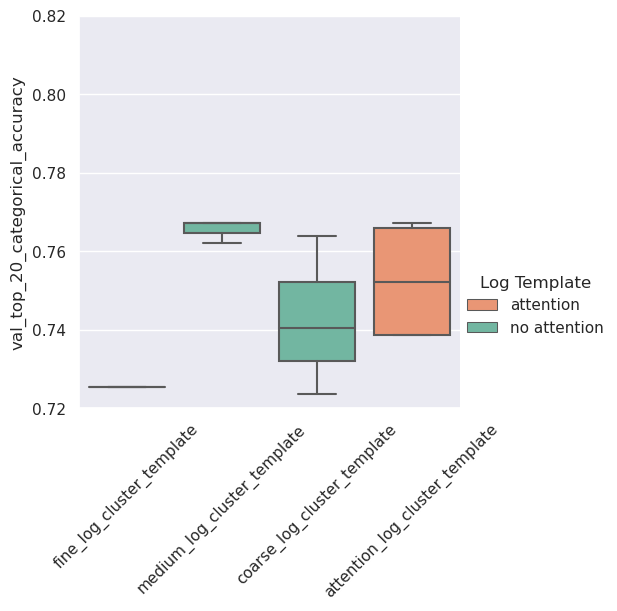

In [177]:
sns.set(font_scale=1)
custom_palette = {"attention": sns.color_palette("Set2")[1], "no attention": sns.color_palette("Set2")[0]}

df = hdfs_metrics_df.copy()
df["data_params_SequenceConfigx_sequence_column_name"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: {
    "": "attention_log_cluster_template"
}.get(x, x))
df["Log Template"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: "attention" if "attention" in x else "no attention")
g = sns.catplot(
    data=df[
        df["data_params_HDFSPreprocessorConfiglog_parser"].apply(lambda x: x == "drain")
       ],
    hue="Log Template",
    x="data_params_SequenceConfigx_sequence_column_name",
    y="val_top_10_categorical_accuracy_history_best",
    row="data_params_SequenceConfigy_sequence_column_name",
    order=["fine_log_cluster_template",  "medium_log_cluster_template", "coarse_log_cluster_template","attention_log_cluster_template"],
    kind="box",
    palette=custom_palette,
    dodge=False,
).set_xticklabels(rotation=45).set_titles("").set_axis_labels('', "val_top_20_categorical_accuracy")
plt.savefig("Drain_2k_HDFS.png", dpi=300, bbox_inches="tight")
plt.ylim(0.72, 0.82)
plt.show()

# Thunderbird

# All algos

In [187]:
mlflow_helper = MlflowHelper(pkl_file=Path("mlflow_run_df.pkl"), experiment_id="921886659731227628")
mlflow_helper.query_valid_runs(pkl_file=Path("mlflow_run_df.pkl"))

Querying data per run...: 0it [00:00, ?it/s]


Queried 0 runs from MLFlow for mimic


Querying data per run...: 0it [00:00, ?it/s]


Queried 0 runs from MLFlow for huawei_logs


Querying data per run...: 0it [00:00, ?it/s]


Queried 0 runs from MLFlow for hdfs


Querying data per run...: 100%|██████████| 96/96 [00:00<00:00, 124.97it/s]

Queried 96 runs from MLFlow for tbird_logs


In [188]:
tbird_df = mlflow_helper.tbird_run_df(
    valid_x_columns=["fine_log_cluster_template_drain", "medium_log_cluster_template_drain", "", "coarse_log_cluster_template_drain", "fine_log_cluster_template_spell", "medium_log_cluster_template_spell",
                     "coarse_log_cluster_template_spell", "fine_log_cluster_template_nulog", "medium_log_cluster_template_nulog", "coarse_log_cluster_template_nulog"],
    valid_y_columns=["attributes"],
)

tbird_df.groupby(by=[
    "data_params_SequenceConfigx_sequence_column_name",
    "data_params_SequenceConfigy_sequence_column_name",
    "data_tags_model_type",
]).agg({
    "info_run_id": len
})

,,,info_run_id
data_params_SequenceConfigx_sequence_column_name,data_params_SequenceConfigy_sequence_column_name,data_tags_model_type,
,attributes,simple,17
coarse_log_cluster_template_drain,attributes,simple,3
coarse_log_cluster_template_nulog,attributes,simple,7
coarse_log_cluster_template_spell,attributes,simple,7
fine_log_cluster_template_drain,attributes,simple,3
fine_log_cluster_template_nulog,attributes,simple,7
fine_log_cluster_template_spell,attributes,simple,7
medium_log_cluster_template_drain,attributes,simple,3
medium_log_cluster_template_nulog,attributes,simple,7


In [189]:
tbird_metrics_df = mlflow_helper.load_best_metrics_for_ids(set(tbird_df["info_run_id"]))

Querying metrics for runs: 100%|██████████| 68/68 [00:03<00:00, 17.01it/s]


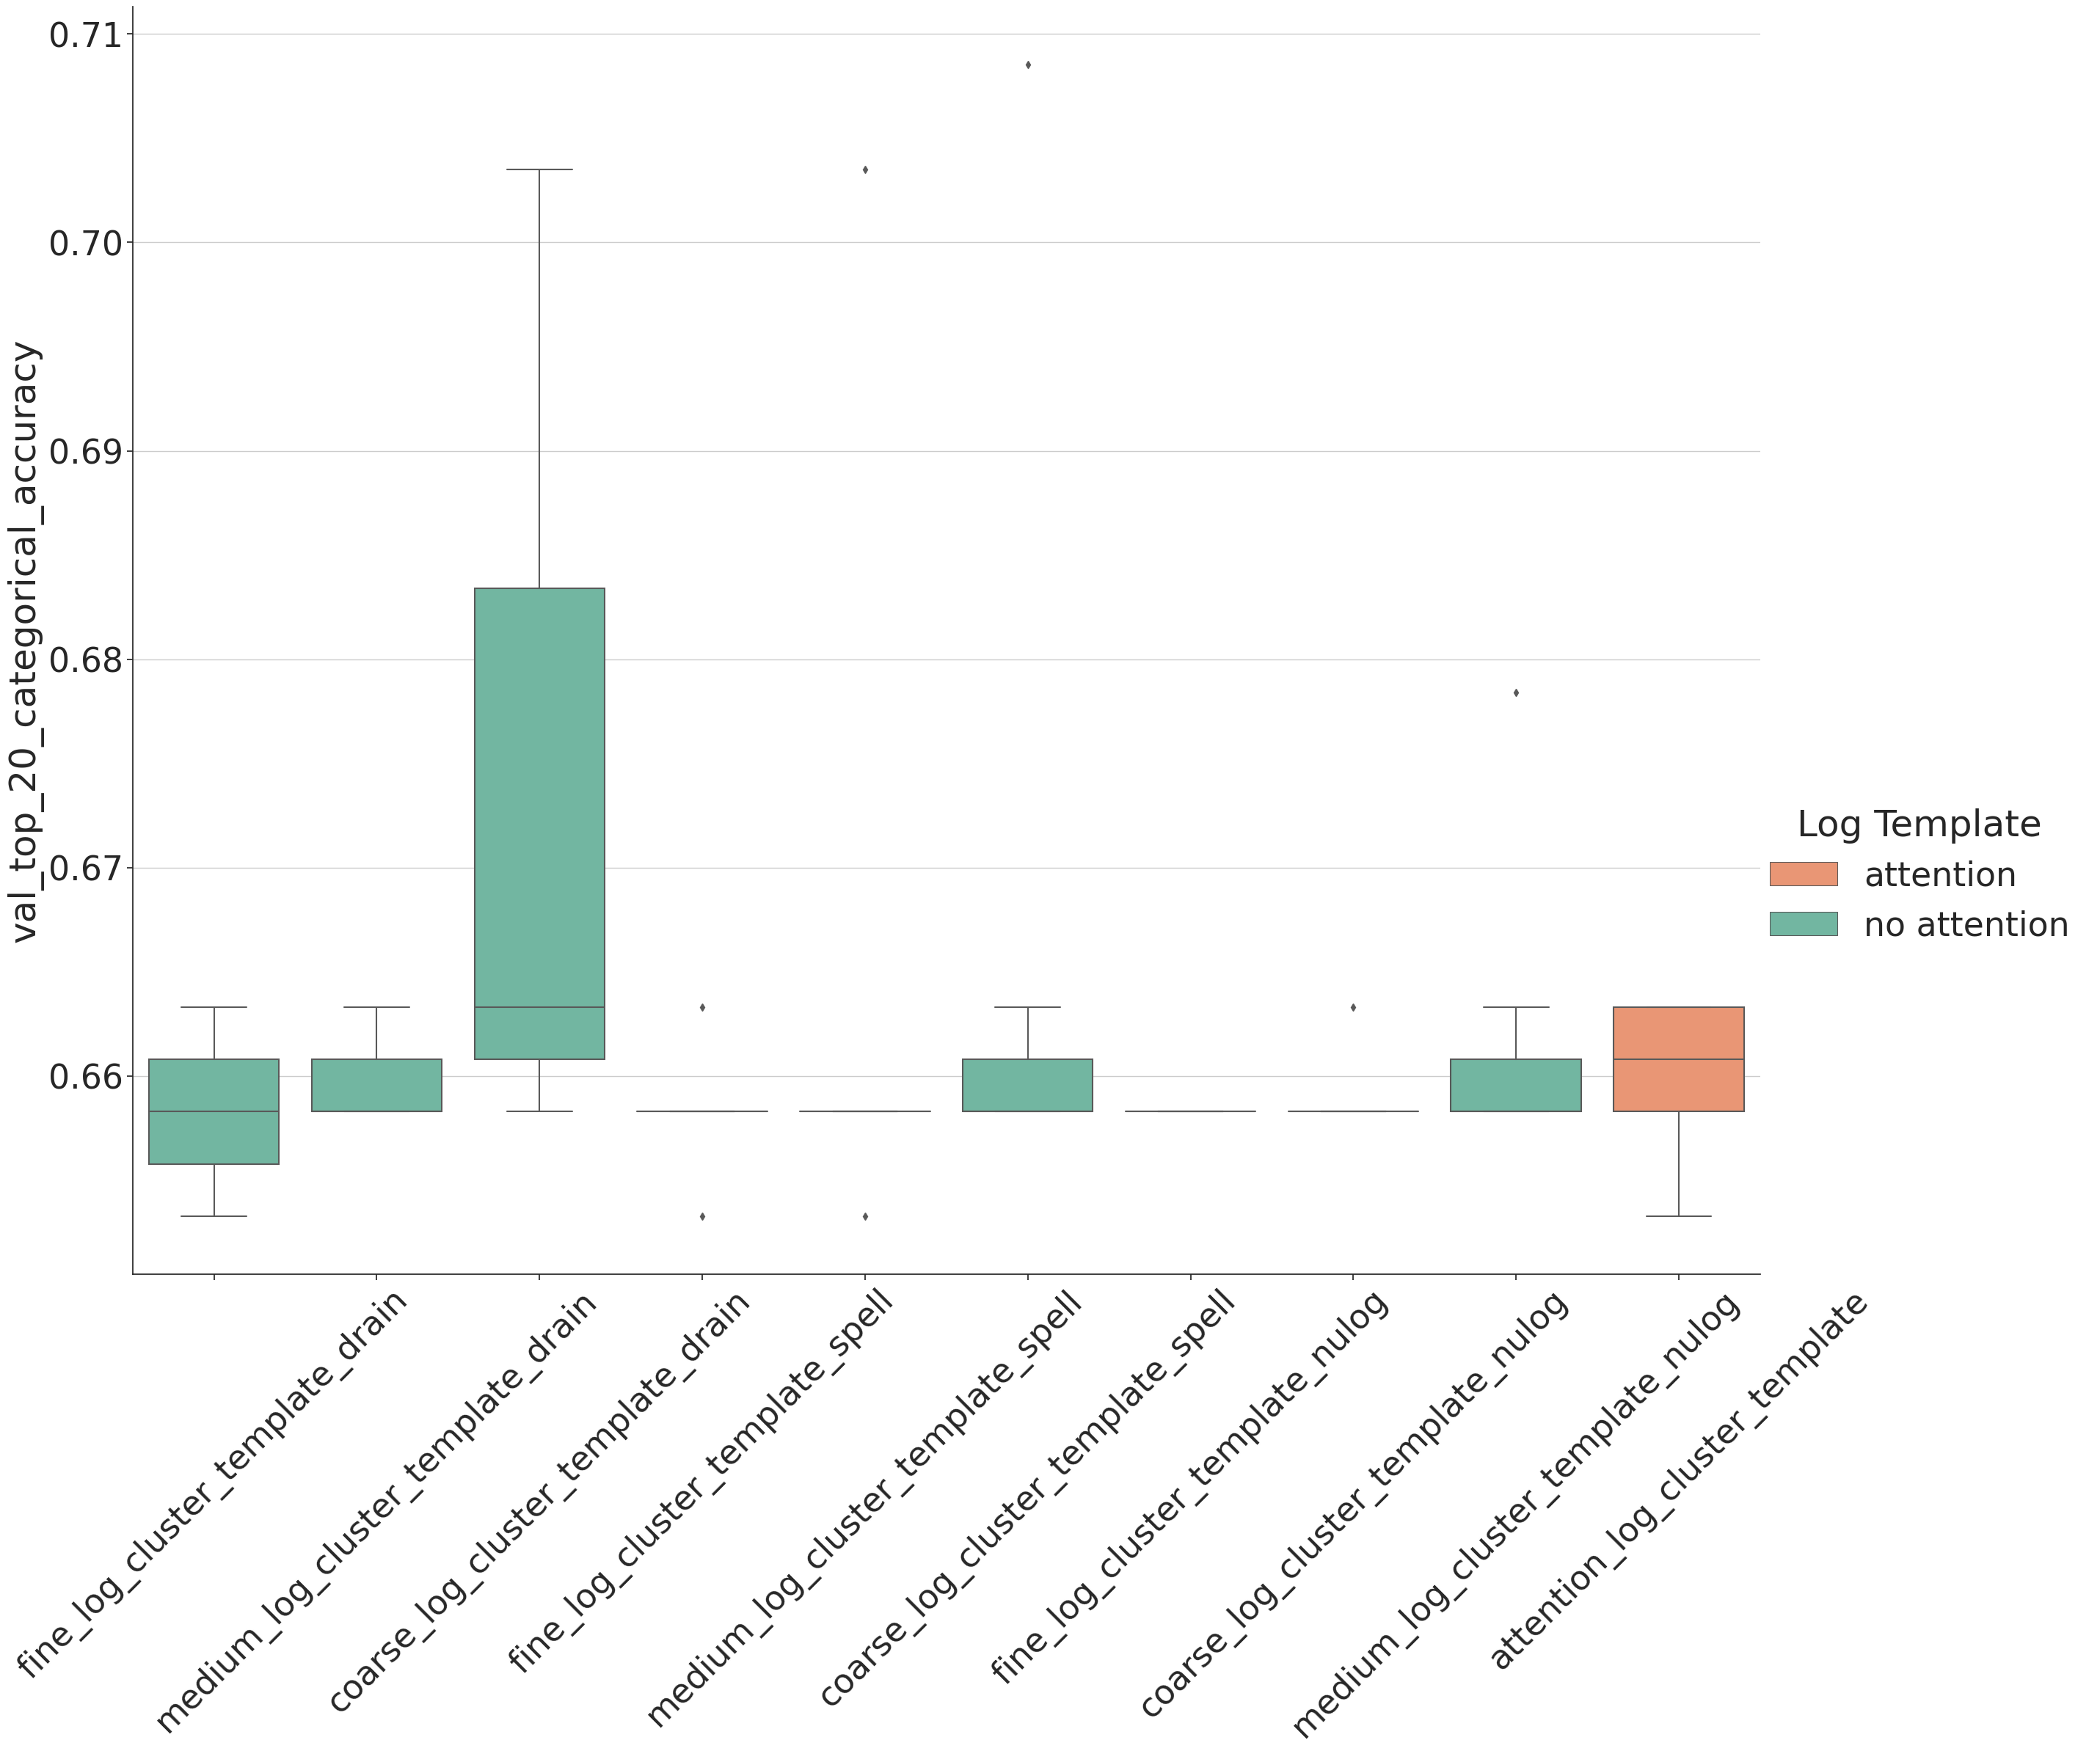

In [208]:
sns.set(font_scale=3)
custom_palette = {"attention": sns.color_palette("Set2")[1], "no attention": sns.color_palette("Set2")[0]}

sns.set_style("ticks",{'axes.grid' : True})
df = tbird_metrics_df.copy()
df["data_params_SequenceConfigx_sequence_column_name"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: {
    "": "attention_log_cluster_template"
}.get(x, x))
df["Log Template"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: "attention" if "attention" in x else "no attention")
g = sns.catplot(
    data=df[
        df["data_params_ThunderBirdPreprocessorConfiglog_parser"].apply(lambda x: x == "all")
     # & df["data_params_ThunderBirdPreprocessorConfigparser_combination"].apply(lambda x: x == "NULOG+SPELL")
        ],
    hue="Log Template",
    x="data_params_SequenceConfigx_sequence_column_name",
    y="val_top_20_categorical_accuracy_history_best",
    row="data_params_SequenceConfigy_sequence_column_name",
    order=[  "fine_log_cluster_template_drain", "medium_log_cluster_template_drain",
           "coarse_log_cluster_template_drain","fine_log_cluster_template_spell", "medium_log_cluster_template_spell",
           "coarse_log_cluster_template_spell", "fine_log_cluster_template_nulog",
           "coarse_log_cluster_template_nulog", "medium_log_cluster_template_nulog", 
           "attention_log_cluster_template"],
    kind="box",
    palette=custom_palette,
    dodge=False,
    height=20,
    aspect=1.3,
).set_xticklabels(rotation=45).set_titles("").set_axis_labels('', "val_top_20_categorical_accuracy")
plt.savefig("all_results_tbird.png", dpi=150, bbox_inches="tight")
#plt.suptitle("NULOG+SPELL Thunderbird")
plt.show()

In [206]:
df = tbird_metrics_df.copy()
df["data_params_SequenceConfigx_sequence_column_name"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: {
    "": "attention_log_cluster_template"
}.get(x, x))
df = df[
        df["data_params_SequenceConfigy_sequence_column_name"].apply(lambda x: x == "attributes")
        & df["data_tags_model_type"].apply(lambda x: x == "simple")
      #  & df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: x == "attention_log_cluster_template")
      #  & df["data_params_HuaweiPreprocessorConfigremove_dates_from_payload"].apply(lambda x: x == "True")
      #  & df["data_params_HuaweiPreprocessorConfigparser_combination"].apply(lambda x: x == "drain+spell")
        & df["data_params_ThunderBirdPreprocessorConfiglog_parser"].apply(lambda x: x == "all")
        ]
df["data_metrics_x_vocab_size"].max()

1545.0

# Single algos

In [12]:
tbird_df = mlflow_helper.tbird_run_df(
    valid_x_columns=["fine_log_cluster_template", "medium_log_cluster_template", "coarse_log_cluster_template", ""],
    valid_y_columns=["attributes"],
)

tbird_df.groupby(by=[
    "data_params_SequenceConfigx_sequence_column_name",
    "data_params_SequenceConfigy_sequence_column_name",
    "data_tags_model_type",
]).agg({
    "info_run_id": len
})

,,,info_run_id
data_params_SequenceConfigx_sequence_column_name,data_params_SequenceConfigy_sequence_column_name,data_tags_model_type,
,attributes,simple,17
coarse_log_cluster_template,attributes,simple,9
fine_log_cluster_template,attributes,simple,10
medium_log_cluster_template,attributes,simple,9


In [13]:
tbird_metrics_df = mlflow_helper.load_best_metrics_for_ids(set(tbird_df["info_run_id"]))

Querying metrics for runs: 100%|██████████| 45/45 [00:02<00:00, 16.83it/s]


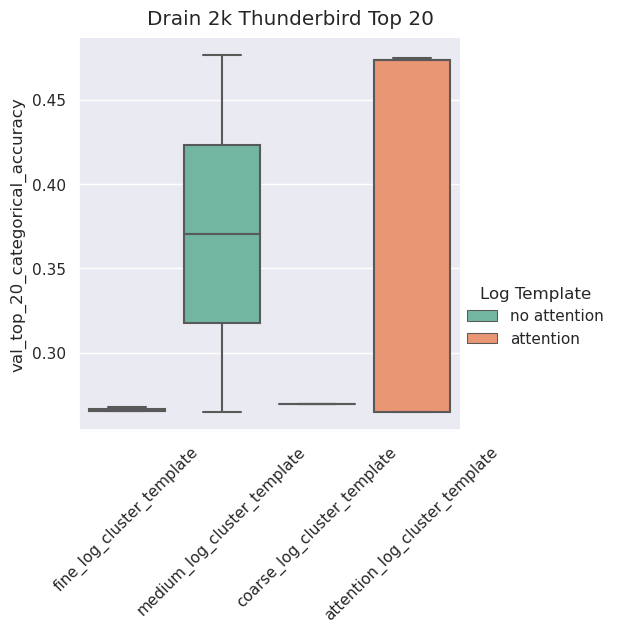

In [18]:
sns.set(font_scale=1)
df = tbird_metrics_df.copy()
df["data_params_SequenceConfigx_sequence_column_name"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: {
    "": "attention_log_cluster_template"
}.get(x, x))
df["Log Template"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: "attention" if "attention" in x else "no attention")
g = sns.catplot(
    data=df[
        df["data_params_ThunderBirdPreprocessorConfiglog_parser"].apply(lambda x: x == "drain")
        ],
    hue="Log Template",
    x="data_params_SequenceConfigx_sequence_column_name",
    y="val_top_20_categorical_accuracy_history_best",
    row="data_params_SequenceConfigy_sequence_column_name",
    order=["fine_log_cluster_template",  "medium_log_cluster_template", "coarse_log_cluster_template","attention_log_cluster_template"],
    kind="box",
    palette="Set2",
    dodge=False,
).set_xticklabels(rotation=45).set_titles("").set_axis_labels('', "val_top_20_categorical_accuracy")
plt.savefig("Nulog_2k_tbird.png", dpi=300, bbox_inches="tight")
plt.suptitle("Drain 2k Thunderbird Top 20")
plt.show()

In [48]:
bgl_df = pd.read_pickle("../bgl.pkl")

In [49]:
bgl_df.columns

Index(['Level', 'Code1', 'Code2', 'Component1', 'Component2', 'timestamp',
       'Payload', 'fine_log_cluster_template', 'fine_log_cluster_path',
       'coarse_log_cluster_template', 'coarse_log_cluster_path',
       'medium_log_cluster_template', 'medium_log_cluster_path'],
      dtype='object')

In [50]:
bgl_df.describe()

/tmp/ipykernel_804602/2422681528.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  bgl_df.describe()


,Level,Code1,Code2,Component1,Component2,timestamp,Payload,fine_log_cluster_template,fine_log_cluster_path,coarse_log_cluster_template,coarse_log_cluster_path,medium_log_cluster_template,medium_log_cluster_path
count,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000
unique,5,1778,1778,2,5,2000,1367,115,113,103,102,114,113
top,INFO,R30-M0-N9-C:J16-U01,R30-M0-N9-C:J16-U01,RAS,KERNEL,2005-06-03 15:42:50.675872,data TLB error interrupt,generating *,2 generating *,generating *,2 generating *,generating *,2 generating *
freq,1597,60,60,1962,1820,1,60,721,721,721,721,721,721
first,NaN,NaN,NaN,NaN,NaN,2005-06-03 15:42:50.675872,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,2006-01-03 07:13:09.127918,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
bgl_df.to_csv("../bgl.csv")